In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [83]:
! pip install transformers
! pip install datasets
! pip install --upgrade tqdm
! pip install pytorch-lightning
! pip install kaggle

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [86]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [87]:
!kaggle datasets download chauri/facebook-hateful-memes

Dataset URL: https://www.kaggle.com/datasets/chauri/facebook-hateful-memes
License(s): unknown
facebook-hateful-memes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [88]:
! unzip facebook-hateful-memes.zip

In [89]:
!pip install transformers

In [90]:
!pip install torcheval

In [91]:
%load_ext autoreload
%autoreload 2

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics.functional import binary_auroc

# model
from transformers import RobertaModel, RobertaTokenizerFast

# general
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# gpu check
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device=='cuda')

2.2.1+cu121
True


In [93]:
#model_name = 'Hate-speech-CNERG/bert-base-uncased-hatexplain'

In [94]:
path = "/content/hateful_memes/"

In [95]:
import pandas as pd
val_seen = pd.read_json(path+'dev_seen.jsonl',lines=True)
val_unseen= pd.read_json(path+'dev_unseen.jsonl',lines=True)
test_seen=pd.read_json(path+'test_seen.jsonl',lines=True)
test_unseen=pd.read_json(path+'test_unseen.jsonl',lines=True)
df_train =pd.read_json(path+'train.jsonl',lines=True)

In [96]:
df_train.label.value_counts()

label
0    5481
1    3019
Name: count, dtype: int64

In [97]:
val_seen.label.value_counts()

label
0    253
1    247
Name: count, dtype: int64

In [98]:
class HatefulMemesDataset(Dataset):
    def __init__(self, jsonl_file, root_dir, transform=None):
        self.annotations = pd.read_json(jsonl_file, lines=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        id = self.annotations.loc[idx, 'id']
        img_path = os.path.join(self.root_dir, self.annotations.loc[idx, 'img'])
        label = self.annotations.loc[idx, 'label']
        text = self.annotations.loc[idx, 'text']

        try:
            # Load image
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                image = self.transform(image)

            sample = {"id": id, "image": image, "label": label, "text": text}

            return sample

        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None

In [99]:
hm_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [100]:
train_jsonl = os.path.join(path, "train.jsonl")
val_seen_jsonl = os.path.join(path, "dev_seen.jsonl")
val_unseen_jsonl = os.path.join(path, "dev_unseen.jsonl")
test_seen_jsonl = os.path.join(path, "test_seen.jsonl")
test_unseen_jsonl = os.path.join(path, "test_unseen.jsonl")

In [101]:
# Create datasets
train_dataset = HatefulMemesDataset(jsonl_file=train_jsonl, root_dir=path, transform=hm_transform)
val_seen_dataset = HatefulMemesDataset(jsonl_file=val_seen_jsonl, root_dir=path, transform=hm_transform)
val_unseen_dataset = HatefulMemesDataset(jsonl_file=val_unseen_jsonl, root_dir=path, transform=hm_transform)
test_seen_dataset = HatefulMemesDataset(jsonl_file=test_seen_jsonl, root_dir=path, transform=hm_transform)
test_unseen_dataset = HatefulMemesDataset(jsonl_file=test_unseen_jsonl, root_dir=path, transform=hm_transform)

In [102]:
# Hyperparameters
batch_size = 64

In [103]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_seen_dataloader = DataLoader(val_seen_dataset, batch_size=batch_size, shuffle=False)
val_unseen_dataloader = DataLoader(val_unseen_dataset, batch_size=batch_size, shuffle=False)
test_seen_dataloader = DataLoader(test_seen_dataset, batch_size=batch_size, shuffle=False)
test_unseen_dataloader = DataLoader(test_unseen_dataset, batch_size=batch_size, shuffle=False)

In [104]:
from torch.utils.data import ConcatDataset

# Combine datasets
val_dataset = ConcatDataset([val_seen_dataset, val_unseen_dataset])
# Combine data loaders
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [105]:
# Combine datasets
test_dataset = ConcatDataset([test_seen_dataset, test_unseen_dataset])
# Combine data loaders
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

 #VGG Model

In [106]:
# vgg16= models.vgg16(weights="vgg16_Weights.DEFAULT", progress=True)

# modules = list(vgg16.children())

# vgg16 = nn.Sequential(*modules[:-1])

# vgg16.to(device)

# for p in vgg16.parameters():
#     p.requires_grad = False
########################################

# import torch
# import torchvision.models as models
# import torch.nn as nn

# # Load the pre-trained VGG model
# vgg16 = models.vgg16(pretrained=True)

# # Extract all the child modules (layers) of the VGG model
# modules = list(vgg16.features.children())

# # Create a new Sequential model containing all layers except the final classification layer
# vgg16_fe = nn.Sequential(*modules[:-1])

# # Move the feature extractor model to the specified device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# vgg16_fe.to(device)

# # Freeze the parameters of the feature extractor
# for p in vgg16_fe.parameters():
#     p.requires_grad = False
########################################
import torch
import torchvision.models as models
import torch.nn as nn

# Load the pre-trained VGG model
vgg16 = models.vgg16(pretrained=True)

# Move the VGG model to the specified device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# Move all parameters of the VGG model to the specified device
for p in vgg16.parameters():
    p.requires_grad = False
    # p.data = p.data.to(device)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# ROBERTA

In [107]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base")

roberta_model.to(device)

for param in roberta_model.parameters():
    param.requires_grad = False

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [108]:
class BaseLineHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_stack = nn.Sequential(
            nn.BatchNorm1d(1768),
            nn.Linear(1768, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 2),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

In [109]:
head = BaseLineHead()
head.to(device)

BaseLineHead(
  (linear_stack): Sequential(
    (0): BatchNorm1d(1768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1768, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [110]:
def get_metrics_and_losses(losses, predictions, labels):
  average_loss = losses.mean().item()
  accuracy = (predictions == labels).sum().item() / labels.numel()

  print(predictions)
  print(labels)
  auroc = binary_auroc(predictions, labels)

  return average_loss, accuracy, auroc

# Test on 1 Batch

In [111]:
sample_test = next(iter(test_seen_dataloader))

torch.Size([64, 3, 256, 256])
tensor(16395)
handjobs sold seperately
tensor(1, device='cuda:0')


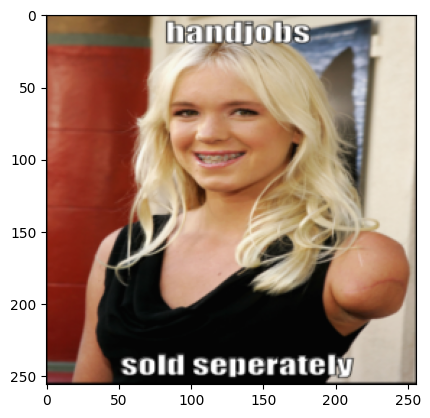

In [112]:
text = sample_test['text']
image = sample_test['image'].to(device)
labels = sample_test['label'].to(device).to(torch.int64)

id = sample_test["id"]

print(image.shape)

print(id[0])
print(text[0])
print(labels[0])
plt.imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))

In [113]:
sample_valid = next(iter(val_seen_dataloader))

torch.Size([64, 3, 256, 256])
tensor(8291)
white people is this a shooting range
tensor(1, device='cuda:0')
torch.float32


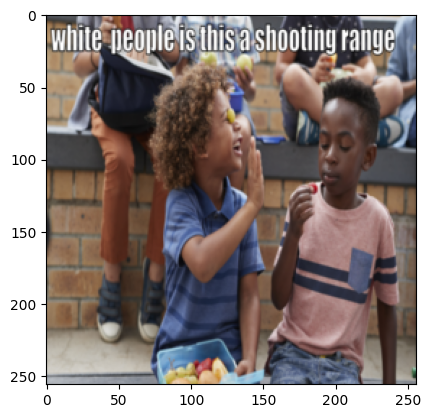

In [114]:
text = sample_valid['text']
image = sample_valid['image'].to(device)
labels = sample_valid['label'].to(device).to(torch.int64)

id = sample_valid["id"]

print(image.shape)

print(id[0])
print(text[0])
print(labels[0])
plt.imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
print(image[0].dtype)

In [115]:
image = image.to(device)
#image = image.float()
image_features = vgg16(image).squeeze()

print(image_features.shape)
print(image_features)

print(torch.max(image_features))
print(torch.min(image_features))

torch.Size([64, 1000])
tensor([[-1.1859, -2.0759, -2.5039,  ..., -1.5716,  4.8612,  4.2458],
        [ 1.4054, -2.1782, -0.5985,  ..., -2.6047,  0.5981,  3.4859],
        [-1.3966, -1.5822, -4.4301,  ..., -3.2801,  0.6277,  5.0484],
        ...,
        [-0.5997,  1.6160,  1.6990,  ...,  0.4542,  2.5272,  1.0214],
        [-0.7263, -2.8105, -1.5172,  ..., -3.0009,  1.3328,  5.5655],
        [-0.4149, -2.8365,  7.0636,  ...,  2.4514,  0.1859,  3.4275]],
       device='cuda:0')
tensor(16.9752, device='cuda:0')
tensor(-10.9004, device='cuda:0')


In [116]:
sample_batch = next(iter(train_dataloader))

torch.Size([64, 3, 256, 256])
king kong
tensor(0, device='cuda:0')
torch.float32


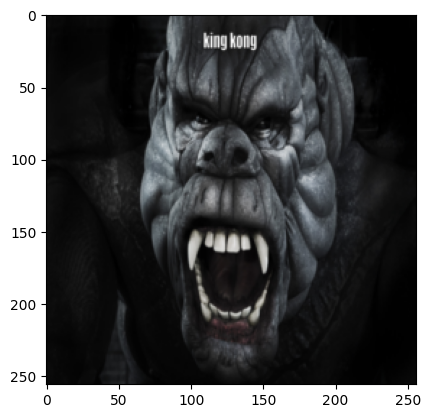

In [117]:
# get inputs
text = sample_batch['text']
image = sample_batch['image'].to(device)
labels = sample_batch['label'].to(device).to(torch.int64)

print(image.shape)

print(text[0])
print(labels[0])

# plt.imshow(image[0].to(torch.int64).cpu().detach().numpy().transpose(1, 2, 0))
plt.imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
print(image[0].dtype)

In [118]:
image = image.float()
image_features = vgg16(image).squeeze()

print(image_features.shape)
print(image_features)

print(torch.max(image_features))
print(torch.min(image_features))

torch.Size([64, 1000])
tensor([[-0.3496,  0.2039, -0.1956,  ..., -1.1071,  1.6636,  4.8174],
        [ 0.6705,  0.6826, -1.7884,  ..., -4.1327,  3.3182,  3.4333],
        [-3.7749,  3.9884,  0.3717,  ..., -4.8858,  3.1376,  8.2847],
        ...,
        [ 2.1676,  0.9474,  2.1456,  ..., -3.2048, -0.3564,  3.2223],
        [ 0.2156, -0.1388, -0.0631,  ..., -2.5964, -0.3424,  3.8693],
        [-0.2677,  0.1605,  0.6752,  ..., -0.5566,  2.8041,  7.3931]],
       device='cuda:0')
tensor(18.4641, device='cuda:0')
tensor(-9.1089, device='cuda:0')


In [119]:
# Get Text Features

tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
text_features = roberta_model(**tokenized_input)

print(text_features["pooler_output"].shape)
print(text_features["pooler_output"])

print(torch.max(text_features["pooler_output"]))
print(torch.min(text_features["pooler_output"]))

torch.Size([64, 768])
tensor([[ 0.1256,  0.0080, -0.3955,  ...,  0.0101,  0.0235, -0.1308],
        [ 0.1295, -0.0143, -0.3995,  ...,  0.0027,  0.0179, -0.1470],
        [ 0.1317,  0.0023, -0.3999,  ...,  0.0175,  0.0118, -0.1207],
        ...,
        [ 0.1393, -0.0101, -0.4242,  ...,  0.0138,  0.0285, -0.1297],
        [ 0.1324,  0.0029, -0.4179,  ...,  0.0044,  0.0156, -0.1452],
        [ 0.1331, -0.0113, -0.3941,  ...,  0.0261,  0.0043, -0.1418]],
       device='cuda:0')
tensor(0.6282, device='cuda:0')
tensor(-0.6252, device='cuda:0')


In [120]:
# concatenate both features

concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)


print(concat_features.shape)
print(concat_features)

print(torch.min(concat_features))
print(torch.max(concat_features))

torch.Size([64, 1768])
tensor([[-3.4956e-01,  2.0390e-01, -1.9559e-01,  ...,  1.0090e-02,
          2.3472e-02, -1.3079e-01],
        [ 6.7051e-01,  6.8261e-01, -1.7884e+00,  ...,  2.7029e-03,
          1.7867e-02, -1.4700e-01],
        [-3.7749e+00,  3.9884e+00,  3.7170e-01,  ...,  1.7461e-02,
          1.1815e-02, -1.2070e-01],
        ...,
        [ 2.1676e+00,  9.4736e-01,  2.1456e+00,  ...,  1.3800e-02,
          2.8477e-02, -1.2966e-01],
        [ 2.1564e-01, -1.3876e-01, -6.3147e-02,  ...,  4.4418e-03,
          1.5584e-02, -1.4521e-01],
        [-2.6768e-01,  1.6054e-01,  6.7521e-01,  ...,  2.6085e-02,
          4.2563e-03, -1.4181e-01]], device='cuda:0')
tensor(-9.1089, device='cuda:0')
tensor(18.4641, device='cuda:0')


In [121]:
#batchnorm = nn.BatchNorm1d(1768).to(device)
numFeatures = concat_features.size(1)
batchnorm = nn.BatchNorm1d(numFeatures).to(device)

normalized_features = batchnorm(concat_features)

In [122]:
print(normalized_features.shape)
print(normalized_features)

print(torch.min(normalized_features))
print(torch.max(normalized_features))

torch.Size([64, 1768])
tensor([[ 0.0194,  0.9215,  0.1001,  ...,  0.1765,  0.7453,  0.4075],
        [ 0.4816,  1.2309, -0.8957,  ..., -0.4801,  0.2383, -1.0545],
        [-1.5325,  3.3672,  0.4548,  ...,  0.8316, -0.3093,  1.3174],
        ...,
        [ 1.1599,  1.4020,  1.5638,  ...,  0.5062,  1.1981,  0.5091],
        [ 0.2755,  0.7001,  0.1829,  ..., -0.3256,  0.0317, -0.8928],
        [ 0.0565,  0.8935,  0.6445,  ...,  1.5982, -0.9932, -0.5859]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
tensor(-5.1552, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4956, device='cuda:0', grad_fn=<MaxBackward1>)


In [123]:
softmax = nn.Softmax(dim=-1)

In [124]:
scores = head(concat_features)

pred = scores.argmax(dim=-1)

print(scores)
print(pred)
print(labels)

tensor([[ 0.2304,  0.2288],
        [ 0.0656,  0.0876],
        [ 0.2544,  0.0921],
        [-0.1142, -0.1631],
        [ 0.2876, -0.0321],
        [ 0.2313,  0.0863],
        [ 0.0362,  0.2766],
        [-0.1205,  0.3232],
        [-0.1174,  0.3376],
        [-0.4585, -0.2380],
        [-0.0751,  0.0160],
        [-0.1093,  0.0811],
        [-0.2146,  0.6483],
        [-0.1166,  0.2064],
        [ 0.1572,  0.2093],
        [-0.0297,  0.1226],
        [-0.0596,  0.1226],
        [ 0.1478,  0.1591],
        [ 0.0910, -0.1960],
        [-0.1541,  0.1163],
        [-0.1940, -0.1094],
        [-0.2912,  0.2845],
        [-0.1936,  0.0523],
        [-0.0724,  0.2603],
        [ 0.3215,  0.1147],
        [-0.1721,  0.0141],
        [-0.0750,  0.4613],
        [-0.1585,  0.1966],
        [ 0.0506,  0.1903],
        [ 0.3068,  0.2684],
        [ 0.6292,  0.3046],
        [-0.3042,  0.0495],
        [-0.0305, -0.2304],
        [ 0.2272,  0.1806],
        [-0.0269,  0.3341],
        [-0.5493,  0

# Train Model

In [125]:
head = BaseLineHead()
head.to(device)

BaseLineHead(
  (linear_stack): Sequential(
    (0): BatchNorm1d(1768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1768, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [126]:
lr = 1e-4
epochs = 10
weight_decay = 1e-3

In [127]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(head.parameters(), lr=lr, weight_decay=weight_decay)

In [128]:
loss = criterion(scores, labels)
print(loss)

loss, acc, auroc = get_metrics_and_losses(loss, pred, labels)

print(loss)
print(acc)
print(auroc)

tensor(0.7439, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
0.7438842058181763
0.421875
tensor(0.5271, device='cuda:0', dtype=torch.float64)


# Training Loop

In [129]:
model_path ="/content/models/"

In [130]:
!mkdir -p models

In [131]:
# train model head
max_validation_auroc = 0

for e in range(epochs):

  # training
  train_losses = torch.zeros(len(train_dataloader)).to(device)
  train_predictions = torch.Tensor().to(device)
  train_labels = torch.Tensor().to(device)

  vgg16.train()
  roberta_model.train()
  head.train()

  for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Epoch " + str(e+1) + " Training"):

    # get inputs
    text = data['text']
    image = data['image'].to(device).float()
    labels = data['label'].to(device).to(torch.int64)

    # zero the parameter gradients
    optimizer.zero_grad()


    # VGG Image Features
    image_features = vgg16(image).squeeze()

    # print("after-VGG")
    # print("pre-BERT")

    # BERT Text Features
    tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
    text_features = roberta_model(**tokenized_input)

    # print("after-BERT")

    # Concatenate Features
    concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

    # print("pre-head")

    # classification head
    scores = torch.squeeze(head(concat_features))
    predictions = scores.argmax(dim=-1)

    # print("after-head")
    # print("pre-backprop")

    # backprop
    loss = criterion(scores, labels)
    loss.backward()
    optimizer.step()

    # print("after-backprop")

    # track values for metric logging
    train_losses[i] = loss
    train_predictions = torch.cat((train_predictions, predictions))
    train_labels = torch.cat((train_labels, labels))

    train_average_loss, train_accuracy, train_auroc = get_metrics_and_losses(train_losses, train_predictions, train_labels)

  # validation
  validate_losses = torch.zeros(len(val_dataloader)).to(device)
  validate_predictions = torch.Tensor().to(device)
  validate_labels = torch.Tensor().to(device)

  vgg16.eval()
  roberta_model.eval()
  head.eval()

  with torch.no_grad():
    for i, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc="Epoch " + str(e+1) + " Validation"):

      # get inputs
      # get inputs
      text = data['text']
      image = data['image'].to(device).float()
      labels = data['label'].to(device).to(torch.int64)

      # vgg16 Image Features
      image_features = vgg16(image).squeeze()

      # BERT Text Features
      tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
      text_features = roberta_model(**tokenized_input)

      # Concatenate Features
      concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

      # classification head
      scores = torch.squeeze(head(concat_features))
      predictions = scores.argmax(dim=-1)

      # loss
      loss = criterion(scores, labels)

      # track values for metric logging
      validate_losses[i] = loss
      validate_predictions = torch.cat((validate_predictions, predictions), dim=0)
      validate_labels = torch.cat((validate_labels, labels), dim=0)

  validate_average_loss, validate_accuracy, validate_auroc = get_metrics_and_losses(validate_losses, validate_predictions, validate_labels)

  # save model
  if validate_auroc > max_validation_auroc:
    max_validation_auroc = validate_auroc
    torch.save(head, model_path +"/concat_roberta_" + str(e+1) + ".pt")
    print("New model saved at epoch " + str(e+1))

  print(train_predictions[:64])
  print(train_labels[:64])
  print(validate_predictions[:64])
  print(validate_labels[:64])

  print("Epoch %d" % (e+1))
  print("Training Loss: %.4f. Validation Loss: %.4f. " % (train_average_loss, validate_average_loss))
  print("Training Accuracy: %.4f. Validation Accuracy: %.4f. " % (train_accuracy, validate_accuracy))
  print("Training AUROC: %.4f. Validation AUROC: %.4f. " % (train_auroc, validate_auroc))
  print("-----------------------------------")


  # looks promising on training - failing to generalize = overfitting
  # add batchnorm (done)
  # inc dropout (done)
  # remove middle layer (not much effect - try reducing hidden size)
  # add weight decay - essentialy explicit L2 regularization -> **best results so far**
  # implement early stopping
  # incr to 20 epochs? -> 40 mins to train...

  # try without sigmoid - maybe better

Epoch 1 Training:   0%|          | 0/133 [00:00<?, ?it/s]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:   1%|          | 1/133 [00:02<05:05,  2.31s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
      

Epoch 1 Training:   2%|▏         | 2/133 [00:04<04:38,  2.13s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 0.

Epoch 1 Training:   3%|▎         | 4/133 [00:11<06:33,  3.05s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:   4%|▍         | 5/133 [00:13<05:50,  2.74s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:   5%|▍         | 6/133 [00:16<05:28,  2.59s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:   5%|▌         | 7/133 [00:18<05:07,  2.44s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:   6%|▌         | 8/133 [00:22<06:12,  2.98s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:   7%|▋         | 9/133 [00:24<05:36,  2.71s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:   8%|▊         | 10/133 [00:26<05:09,  2.52s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:   8%|▊         | 11/133 [00:29<05:06,  2.51s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:   9%|▉         | 12/133 [00:31<05:05,  2.52s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:  10%|▉         | 13/133 [00:36<06:12,  3.11s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:  11%|█         | 14/133 [00:38<05:49,  2.93s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:  11%|█▏        | 15/133 [00:40<04:56,  2.51s/it]

tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

Epoch 1 Training:  12%|█▏        | 16/133 [00:41<04:19,  2.22s/it]

tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  13%|█▎        | 17/133 [00:43<03:54,  2.02s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  14%|█▎        | 18/133 [00:44<03:38,  1.90s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  14%|█▍        | 19/133 [00:46<03:20,  1.76s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 1 Training:  15%|█▌        | 20/133 [00:48<03:22,  1.80s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  16%|█▌        | 21/133 [00:50<03:26,  1.85s/it]

tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  17%|█▋        | 22/133 [00:51<03:14,  1.75s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  17%|█▋        | 23/133 [00:53<03:05,  1.69s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  18%|█▊        | 24/133 [00:54<02:56,  1.62s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  19%|█▉        | 25/133 [00:56<02:51,  1.59s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  20%|█▉        | 26/133 [00:57<02:45,  1.55s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  20%|██        | 27/133 [00:59<02:44,  1.55s/it]

tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 1 Training:  21%|██        | 28/133 [01:01<02:48,  1.60s/it]

tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 1 Training:  22%|██▏       | 29/133 [01:02<02:57,  1.70s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 1 Training:  23%|██▎       | 30/133 [01:04<02:55,  1.70s/it]

tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  23%|██▎       | 31/133 [01:06<02:46,  1.63s/it]

tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  24%|██▍       | 32/133 [01:07<02:42,  1.60s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  25%|██▍       | 33/133 [01:09<02:36,  1.56s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  26%|██▌       | 34/133 [01:10<02:38,  1.60s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  26%|██▋       | 35/133 [01:12<02:32,  1.56s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  27%|██▋       | 36/133 [01:13<02:30,  1.55s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  28%|██▊       | 37/133 [01:15<02:40,  1.67s/it]

tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  29%|██▊       | 38/133 [01:17<02:45,  1.74s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  29%|██▉       | 39/133 [01:19<02:38,  1.69s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  30%|███       | 40/133 [01:20<02:32,  1.64s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  31%|███       | 41/133 [01:22<02:27,  1.61s/it]

tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  32%|███▏      | 42/133 [01:23<02:25,  1.59s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  32%|███▏      | 43/133 [01:25<02:25,  1.61s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  33%|███▎      | 44/133 [01:27<02:20,  1.58s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  34%|███▍      | 45/133 [01:28<02:26,  1.66s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  35%|███▍      | 46/133 [01:30<02:32,  1.75s/it]

tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  35%|███▌      | 47/133 [01:32<02:26,  1.70s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  36%|███▌      | 48/133 [01:33<02:21,  1.66s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  37%|███▋      | 49/133 [01:35<02:17,  1.64s/it]

tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  38%|███▊      | 50/133 [01:37<02:13,  1.61s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  38%|███▊      | 51/133 [01:38<02:10,  1.59s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  39%|███▉      | 52/133 [01:40<02:09,  1.59s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  40%|███▉      | 53/133 [01:42<02:14,  1.68s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  41%|████      | 54/133 [01:44<02:17,  1.74s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  41%|████▏     | 55/133 [01:45<02:12,  1.70s/it]

tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  42%|████▏     | 56/133 [01:47<02:07,  1.65s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  43%|████▎     | 57/133 [01:48<02:03,  1.63s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  44%|████▎     | 58/133 [01:50<01:58,  1.58s/it]

tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  44%|████▍     | 59/133 [01:51<01:57,  1.59s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  45%|████▌     | 60/133 [01:53<01:54,  1.57s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  46%|████▌     | 61/133 [01:55<01:56,  1.62s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  47%|████▋     | 62/133 [01:57<02:02,  1.72s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  47%|████▋     | 63/133 [01:58<02:00,  1.72s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  48%|████▊     | 64/133 [02:00<02:06,  1.84s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 1 Training:  49%|████▉     | 65/133 [02:02<01:58,  1.74s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  50%|████▉     | 66/133 [02:03<01:52,  1.68s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  50%|█████     | 67/133 [02:05<01:46,  1.61s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 1 Training:  51%|█████     | 68/133 [02:06<01:44,  1.60s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  52%|█████▏    | 69/133 [02:08<01:45,  1.65s/it]

tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  53%|█████▎    | 70/133 [02:10<01:48,  1.72s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  53%|█████▎    | 71/133 [02:12<01:44,  1.68s/it]

tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  54%|█████▍    | 72/133 [02:13<01:38,  1.62s/it]

tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 1 Training:  55%|█████▍    | 73/133 [02:15<01:34,  1.57s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  56%|█████▌    | 74/133 [02:16<01:31,  1.56s/it]

tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  56%|█████▋    | 75/133 [02:18<01:29,  1.54s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  57%|█████▋    | 76/133 [02:19<01:26,  1.52s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  58%|█████▊    | 77/133 [02:21<01:27,  1.56s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  59%|█████▊    | 78/133 [02:23<01:34,  1.72s/it]

tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 1 Training:  59%|█████▉    | 79/133 [02:25<01:44,  1.93s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  60%|██████    | 80/133 [02:28<01:48,  2.04s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  61%|██████    | 81/133 [02:29<01:38,  1.89s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  62%|██████▏   | 82/133 [02:31<01:32,  1.82s/it]

tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  62%|██████▏   | 83/133 [02:32<01:27,  1.75s/it]

tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  63%|██████▎   | 84/133 [02:34<01:22,  1.69s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  64%|██████▍   | 85/133 [02:36<01:25,  1.78s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  65%|██████▍   | 86/133 [02:38<01:25,  1.82s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  65%|██████▌   | 87/133 [02:39<01:19,  1.73s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  66%|██████▌   | 88/133 [02:41<01:14,  1.66s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 1 Training:  67%|██████▋   | 89/133 [02:42<01:11,  1.62s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 1 Training:  68%|██████▊   | 90/133 [02:44<01:08,  1.60s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 1 Training:  68%|██████▊   | 91/133 [02:45<01:07,  1.60s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  69%|██████▉   | 92/133 [02:47<01:04,  1.57s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  70%|██████▉   | 93/133 [02:49<01:05,  1.64s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 1 Training:  71%|███████   | 94/133 [02:51<01:05,  1.67s/it]

tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  71%|███████▏  | 95/133 [02:52<01:02,  1.64s/it]

tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  72%|███████▏  | 96/133 [02:54<00:59,  1.61s/it]

tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 1 Training:  73%|███████▎  | 97/133 [02:55<00:57,  1.60s/it]

tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  74%|███████▎  | 98/133 [02:57<00:54,  1.55s/it]

tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  74%|███████▍  | 99/133 [02:58<00:52,  1.54s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  75%|███████▌  | 100/133 [03:00<00:50,  1.54s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  76%|███████▌  | 101/133 [03:01<00:49,  1.56s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  77%|███████▋  | 102/133 [03:03<00:52,  1.69s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  77%|███████▋  | 103/133 [03:05<00:51,  1.71s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  78%|███████▊  | 104/133 [03:07<00:48,  1.67s/it]

tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  79%|███████▉  | 105/133 [03:08<00:45,  1.61s/it]

tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  80%|███████▉  | 106/133 [03:10<00:42,  1.57s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  80%|████████  | 107/133 [03:11<00:40,  1.57s/it]

tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  81%|████████  | 108/133 [03:13<00:40,  1.61s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  82%|████████▏ | 109/133 [03:15<00:41,  1.72s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  83%|████████▎ | 110/133 [03:17<00:43,  1.88s/it]

tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  83%|████████▎ | 111/133 [03:19<00:41,  1.89s/it]

tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  84%|████████▍ | 112/133 [03:21<00:37,  1.79s/it]

tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  85%|████████▍ | 113/133 [03:22<00:33,  1.70s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  86%|████████▌ | 114/133 [03:24<00:31,  1.64s/it]

tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  86%|████████▋ | 115/133 [03:25<00:29,  1.62s/it]

tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  87%|████████▋ | 116/133 [03:27<00:27,  1.62s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 1 Training:  88%|████████▊ | 117/133 [03:28<00:25,  1.59s/it]

tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  89%|████████▊ | 118/133 [03:30<00:25,  1.72s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 1 Training:  89%|████████▉ | 119/133 [03:32<00:25,  1.79s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  90%|█████████ | 120/133 [03:34<00:22,  1.71s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  91%|█████████ | 121/133 [03:35<00:20,  1.68s/it]

tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  92%|█████████▏| 122/133 [03:37<00:18,  1.64s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  92%|█████████▏| 123/133 [03:38<00:16,  1.61s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  93%|█████████▎| 124/133 [03:40<00:14,  1.58s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 1 Training:  94%|█████████▍| 125/133 [03:42<00:12,  1.57s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  95%|█████████▍| 126/133 [03:43<00:11,  1.68s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 1 Training:  95%|█████████▌| 127/133 [03:46<00:10,  1.80s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 1 Training:  96%|█████████▌| 128/133 [03:47<00:08,  1.71s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 1 Training:  97%|█████████▋| 129/133 [03:49<00:06,  1.65s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Training:  98%|█████████▊| 130/133 [03:50<00:04,  1.59s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 1 Training:  98%|█████████▊| 131/133 [03:52<00:03,  1.58s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 1 Training:  99%|█████████▉| 132/133 [03:53<00:01,  1.55s/it]

tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 1 Training: 100%|██████████| 133/133 [03:54<00:00,  1.77s/it]


tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 1 Validation: 100%|██████████| 17/17 [00:24<00:00,  1.43s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')
New model saved at epoch 1
tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0

Epoch 2 Training:   1%|          | 1/133 [00:01<03:08,  1.43s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 0., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:   2%|▏         | 2/133 [00:03<03:24,  1.56s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
      

Epoch 2 Training:   2%|▏         | 3/133 [00:04<03:42,  1.71s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0.

Epoch 2 Training:   3%|▎         | 4/133 [00:06<03:53,  1.81s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:   4%|▍         | 5/133 [00:08<03:38,  1.71s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:   5%|▍         | 6/133 [00:09<03:25,  1.62s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:   5%|▌         | 7/133 [00:11<03:20,  1.59s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:   6%|▌         | 8/133 [00:12<03:12,  1.54s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:   7%|▋         | 9/133 [00:14<03:12,  1.55s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:   8%|▊         | 10/133 [00:15<03:07,  1.53s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:   8%|▊         | 11/133 [00:17<03:13,  1.58s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:   9%|▉         | 12/133 [00:19<03:26,  1.71s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:  10%|▉         | 13/133 [00:21<03:17,  1.64s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:  11%|█         | 14/133 [00:22<03:16,  1.65s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:  11%|█▏        | 15/133 [00:24<03:10,  1.61s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Epoch 2 Training:  12%|█▏        | 16/133 [00:25<03:08,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  13%|█▎        | 17/133 [00:27<03:06,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  14%|█▎        | 18/133 [00:29<03:03,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  14%|█▍        | 19/133 [00:30<03:02,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  15%|█▌        | 20/133 [00:32<03:15,  1.73s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  16%|█▌        | 21/133 [00:34<03:11,  1.71s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  17%|█▋        | 22/133 [00:35<03:03,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 2 Training:  17%|█▋        | 23/133 [00:37<02:56,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  18%|█▊        | 24/133 [00:38<02:50,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  19%|█▉        | 25/133 [00:40<02:46,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  20%|█▉        | 26/133 [00:41<02:44,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  20%|██        | 27/133 [00:43<02:39,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 2 Training:  21%|██        | 28/133 [00:45<02:53,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  22%|██▏       | 29/133 [00:47<02:58,  1.72s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 2 Training:  23%|██▎       | 30/133 [00:48<02:51,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  23%|██▎       | 31/133 [00:50<02:43,  1.61s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 2 Training:  24%|██▍       | 32/133 [00:51<02:39,  1.57s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  25%|██▍       | 33/133 [00:53<02:37,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  26%|██▌       | 34/133 [00:54<02:32,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  26%|██▋       | 35/133 [00:56<02:32,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  27%|██▋       | 36/133 [00:58<02:41,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  28%|██▊       | 37/133 [01:00<02:46,  1.73s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  29%|██▊       | 38/133 [01:01<02:38,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 2 Training:  29%|██▉       | 39/133 [01:03<02:31,  1.61s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 2 Training:  30%|███       | 40/133 [01:04<02:25,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  31%|███       | 41/133 [01:06<02:21,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  32%|███▏      | 42/133 [01:07<02:18,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  32%|███▏      | 43/133 [01:09<02:15,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  33%|███▎      | 44/133 [01:10<02:17,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  34%|███▍      | 45/133 [01:12<02:30,  1.71s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  35%|███▍      | 46/133 [01:14<02:20,  1.62s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 2 Training:  35%|███▌      | 47/133 [01:15<02:15,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  36%|███▌      | 48/133 [01:17<02:11,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 2 Training:  37%|███▋      | 49/133 [01:18<02:08,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 2 Training:  38%|███▊      | 50/133 [01:20<02:05,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  38%|███▊      | 51/133 [01:21<02:03,  1.51s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 2 Training:  39%|███▉      | 52/133 [01:23<02:01,  1.49s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  40%|███▉      | 53/133 [01:24<02:07,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  41%|████      | 54/133 [01:26<02:17,  1.74s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  41%|████▏     | 55/133 [01:28<02:09,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  42%|████▏     | 56/133 [01:29<02:04,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  43%|████▎     | 57/133 [01:31<02:01,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  44%|████▎     | 58/133 [01:32<01:56,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  44%|████▍     | 59/133 [01:34<01:53,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  45%|████▌     | 60/133 [01:35<01:51,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  46%|████▌     | 61/133 [01:37<01:57,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  47%|████▋     | 62/133 [01:39<02:07,  1.79s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 2 Training:  47%|████▋     | 63/133 [01:41<01:58,  1.69s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  48%|████▊     | 64/133 [01:42<01:52,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  49%|████▉     | 65/133 [01:44<01:47,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 2 Training:  50%|████▉     | 66/133 [01:45<01:43,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 2 Training:  50%|█████     | 67/133 [01:47<01:43,  1.56s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 2 Training:  51%|█████     | 68/133 [01:48<01:40,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  52%|█████▏    | 69/133 [01:50<01:41,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  53%|█████▎    | 70/133 [01:52<01:45,  1.67s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 2 Training:  53%|█████▎    | 71/133 [01:54<01:41,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  54%|█████▍    | 72/133 [01:55<01:37,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  55%|█████▍    | 73/133 [01:56<01:32,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  56%|█████▌    | 74/133 [01:58<01:29,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  56%|█████▋    | 75/133 [01:59<01:28,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  57%|█████▋    | 76/133 [02:01<01:25,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 2 Training:  58%|█████▊    | 77/133 [02:03<01:26,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  59%|█████▊    | 78/133 [02:05<01:33,  1.70s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  59%|█████▉    | 79/133 [02:06<01:32,  1.71s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  60%|██████    | 80/133 [02:08<01:28,  1.67s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  61%|██████    | 81/133 [02:09<01:25,  1.65s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  62%|██████▏   | 82/133 [02:11<01:21,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  62%|██████▏   | 83/133 [02:13<01:18,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 2 Training:  63%|██████▎   | 84/133 [02:14<01:15,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 2 Training:  64%|██████▍   | 85/133 [02:15<01:12,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  65%|██████▍   | 86/133 [02:17<01:18,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 2 Training:  65%|██████▌   | 87/133 [02:19<01:21,  1.76s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  66%|██████▌   | 88/133 [02:21<01:15,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 2 Training:  67%|██████▋   | 89/133 [02:22<01:10,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  68%|██████▊   | 90/133 [02:24<01:08,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  68%|██████▊   | 91/133 [02:25<01:06,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  69%|██████▉   | 92/133 [02:27<01:03,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 2 Training:  70%|██████▉   | 93/133 [02:28<01:01,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  71%|███████   | 94/133 [02:30<01:01,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  71%|███████▏  | 95/133 [02:32<01:03,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  72%|███████▏  | 96/133 [02:33<00:59,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  73%|███████▎  | 97/133 [02:35<00:56,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  74%|███████▎  | 98/133 [02:36<00:54,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 2 Training:  74%|███████▍  | 99/133 [02:38<00:52,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 2 Training:  75%|███████▌  | 100/133 [02:39<00:49,  1.51s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  76%|███████▌  | 101/133 [02:41<00:47,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 2 Training:  77%|███████▋  | 102/133 [02:42<00:46,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  77%|███████▋  | 103/133 [02:44<00:49,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  78%|███████▊  | 104/133 [02:46<00:49,  1.71s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 2 Training:  79%|███████▉  | 105/133 [02:48<00:46,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  80%|███████▉  | 106/133 [02:49<00:43,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  80%|████████  | 107/133 [02:51<00:41,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  81%|████████  | 108/133 [02:52<00:40,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  82%|████████▏ | 109/133 [02:54<00:38,  1.60s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  83%|████████▎ | 110/133 [02:56<00:36,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  83%|████████▎ | 111/133 [02:58<00:37,  1.69s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 2 Training:  84%|████████▍ | 112/133 [03:00<00:39,  1.86s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 2 Training:  85%|████████▍ | 113/133 [03:02<00:38,  1.91s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  86%|████████▌ | 114/133 [03:03<00:34,  1.80s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 2 Training:  86%|████████▋ | 115/133 [03:05<00:30,  1.70s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 2 Training:  87%|████████▋ | 116/133 [03:06<00:27,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  88%|████████▊ | 117/133 [03:08<00:25,  1.59s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  89%|████████▊ | 118/133 [03:09<00:23,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  89%|████████▉ | 119/133 [03:11<00:23,  1.65s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training:  90%|█████████ | 120/133 [03:13<00:22,  1.76s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 2 Training:  91%|█████████ | 121/133 [03:15<00:20,  1.70s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  92%|█████████▏| 122/133 [03:16<00:18,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  92%|█████████▏| 123/133 [03:18<00:16,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  93%|█████████▎| 124/133 [03:19<00:14,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 2 Training:  94%|█████████▍| 125/133 [03:21<00:12,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  95%|█████████▍| 126/133 [03:22<00:10,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  95%|█████████▌| 127/133 [03:24<00:09,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 2 Training:  96%|█████████▌| 128/133 [03:26<00:08,  1.77s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 2 Training:  97%|█████████▋| 129/133 [03:28<00:06,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 2 Training:  98%|█████████▊| 130/133 [03:29<00:04,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 2 Training:  98%|█████████▊| 131/133 [03:31<00:03,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 2 Training:  99%|█████████▉| 132/133 [03:32<00:01,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Training: 100%|██████████| 133/133 [03:33<00:00,  1.61s/it]


tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 2 Validation: 100%|██████████| 17/17 [00:23<00:00,  1.40s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')
New model saved at epoch 2
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0

Epoch 3 Training:   1%|          | 1/133 [00:01<03:18,  1.50s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:   2%|▏         | 2/133 [00:02<03:12,  1.47s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
      

Epoch 3 Training:   2%|▏         | 3/133 [00:04<03:13,  1.49s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0.

Epoch 3 Training:   3%|▎         | 4/133 [00:06<03:18,  1.54s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:   4%|▍         | 5/133 [00:07<03:31,  1.65s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:   5%|▍         | 6/133 [00:09<03:32,  1.67s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:   5%|▌         | 7/133 [00:11<03:24,  1.62s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:   6%|▌         | 8/133 [00:12<03:17,  1.58s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:   7%|▋         | 9/133 [00:14<03:12,  1.55s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:   8%|▊         | 10/133 [00:15<03:08,  1.53s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:   8%|▊         | 11/133 [00:17<03:05,  1.52s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:   9%|▉         | 12/133 [00:18<03:02,  1.51s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:  10%|▉         | 13/133 [00:20<03:13,  1.61s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:  11%|█         | 14/133 [00:22<03:22,  1.70s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:  11%|█▏        | 15/133 [00:23<03:13,  1.64s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 

Epoch 3 Training:  12%|█▏        | 16/133 [00:25<03:06,  1.60s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  13%|█▎        | 17/133 [00:27<03:08,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 3 Training:  14%|█▎        | 18/133 [00:28<03:04,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  14%|█▍        | 19/133 [00:29<02:55,  1.54s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 3 Training:  15%|█▌        | 20/133 [00:31<02:49,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 3 Training:  16%|█▌        | 21/133 [00:32<02:51,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 3 Training:  17%|█▋        | 22/133 [00:34<03:03,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 3 Training:  17%|█▋        | 23/133 [00:36<02:58,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  18%|█▊        | 24/133 [00:37<02:50,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  19%|█▉        | 25/133 [00:39<02:47,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  20%|█▉        | 26/133 [00:40<02:43,  1.53s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 3 Training:  20%|██        | 27/133 [00:42<02:42,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  21%|██        | 28/133 [00:43<02:36,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  22%|██▏       | 29/133 [00:45<02:34,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  23%|██▎       | 30/133 [00:47<02:47,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  23%|██▎       | 31/133 [00:49<02:58,  1.75s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  24%|██▍       | 32/133 [00:50<02:49,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 3 Training:  25%|██▍       | 33/133 [00:52<02:41,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  26%|██▌       | 34/133 [00:53<02:38,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  26%|██▋       | 35/133 [00:55<02:33,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  27%|██▋       | 36/133 [00:56<02:30,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  28%|██▊       | 37/133 [00:58<02:26,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  29%|██▊       | 38/133 [01:00<02:32,  1.61s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  29%|██▉       | 39/133 [01:01<02:36,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 3 Training:  30%|███       | 40/133 [01:03<02:28,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  31%|███       | 41/133 [01:04<02:23,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  32%|███▏      | 42/133 [01:06<02:20,  1.54s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 3 Training:  32%|███▏      | 43/133 [01:07<02:18,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  33%|███▎      | 44/133 [01:09<02:14,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  34%|███▍      | 45/133 [01:10<02:09,  1.48s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 3 Training:  35%|███▍      | 46/133 [01:12<02:08,  1.48s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  35%|███▌      | 47/133 [01:14<02:17,  1.60s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 3 Training:  36%|███▌      | 48/133 [01:15<02:19,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 3 Training:  37%|███▋      | 49/133 [01:17<02:12,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  38%|███▊      | 50/133 [01:18<02:08,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  38%|███▊      | 51/133 [01:20<02:03,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  39%|███▉      | 52/133 [01:21<02:00,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 3 Training:  40%|███▉      | 53/133 [01:23<01:58,  1.48s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  41%|████      | 54/133 [01:24<01:55,  1.46s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 3 Training:  41%|████▏     | 55/133 [01:26<01:56,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  42%|████▏     | 56/133 [01:27<02:03,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 3 Training:  43%|████▎     | 57/133 [01:29<02:03,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  44%|████▎     | 58/133 [01:31<01:59,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 3 Training:  44%|████▍     | 59/133 [01:32<01:55,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  45%|████▌     | 60/133 [01:34<01:52,  1.54s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  46%|████▌     | 61/133 [01:35<01:49,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 3 Training:  47%|████▋     | 62/133 [01:36<01:46,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 3 Training:  47%|████▋     | 63/133 [01:38<01:44,  1.49s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  48%|████▊     | 64/133 [01:40<01:51,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 3 Training:  49%|████▉     | 65/133 [01:42<01:53,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  50%|████▉     | 66/133 [01:43<01:48,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  50%|█████     | 67/133 [01:45<01:47,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  51%|█████     | 68/133 [01:46<01:41,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  52%|█████▏    | 69/133 [01:48<01:39,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  53%|█████▎    | 70/133 [01:49<01:36,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  53%|█████▎    | 71/133 [01:51<01:32,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  54%|█████▍    | 72/133 [01:52<01:35,  1.57s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  55%|█████▍    | 73/133 [01:54<01:39,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  56%|█████▌    | 74/133 [01:56<01:34,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  56%|█████▋    | 75/133 [01:57<01:30,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  57%|█████▋    | 76/133 [01:59<01:26,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  58%|█████▊    | 77/133 [02:00<01:23,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  59%|█████▊    | 78/133 [02:02<01:22,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  59%|█████▉    | 79/133 [02:03<01:20,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  60%|██████    | 80/133 [02:05<01:19,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 3 Training:  61%|██████    | 81/133 [02:07<01:25,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  62%|██████▏   | 82/133 [02:08<01:25,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  62%|██████▏   | 83/133 [02:10<01:20,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  63%|██████▎   | 84/133 [02:11<01:17,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  64%|██████▍   | 85/133 [02:13<01:13,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  65%|██████▍   | 86/133 [02:14<01:11,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 3 Training:  65%|██████▌   | 87/133 [02:16<01:09,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 3 Training:  66%|██████▌   | 88/133 [02:17<01:08,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 3 Training:  67%|██████▋   | 89/133 [02:19<01:11,  1.63s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  68%|██████▊   | 90/133 [02:21<01:13,  1.70s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  68%|██████▊   | 91/133 [02:22<01:09,  1.65s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  69%|██████▉   | 92/133 [02:24<01:06,  1.62s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 3 Training:  70%|██████▉   | 93/133 [02:25<01:01,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  71%|███████   | 94/133 [02:27<00:58,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  71%|███████▏  | 95/133 [02:28<00:56,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 3 Training:  72%|███████▏  | 96/133 [02:30<00:56,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  73%|███████▎  | 97/133 [02:31<00:54,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  74%|███████▎  | 98/133 [02:33<00:57,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  74%|███████▍  | 99/133 [02:35<00:56,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  75%|███████▌  | 100/133 [02:37<00:55,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  76%|███████▌  | 101/133 [02:38<00:51,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  77%|███████▋  | 102/133 [02:40<00:48,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  77%|███████▋  | 103/133 [02:41<00:46,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  78%|███████▊  | 104/133 [02:43<00:44,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  79%|███████▉  | 105/133 [02:44<00:42,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  80%|███████▉  | 106/133 [02:46<00:45,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  80%|████████  | 107/133 [02:48<00:44,  1.71s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 3 Training:  81%|████████  | 108/133 [02:50<00:41,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  82%|████████▏ | 109/133 [02:51<00:38,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  83%|████████▎ | 110/133 [02:52<00:36,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 3 Training:  83%|████████▎ | 111/133 [02:54<00:33,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  84%|████████▍ | 112/133 [02:55<00:31,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  85%|████████▍ | 113/133 [02:57<00:30,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 3 Training:  86%|████████▌ | 114/133 [02:58<00:29,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  86%|████████▋ | 115/133 [03:00<00:30,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  87%|████████▋ | 116/133 [03:02<00:27,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  88%|████████▊ | 117/133 [03:03<00:25,  1.60s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 3 Training:  89%|████████▊ | 118/133 [03:05<00:23,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 3 Training:  89%|████████▉ | 119/133 [03:07<00:23,  1.70s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  90%|█████████ | 120/133 [03:09<00:21,  1.69s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  91%|█████████ | 121/133 [03:10<00:19,  1.63s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  92%|█████████▏| 122/133 [03:12<00:17,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 3 Training:  92%|█████████▏| 123/133 [03:14<00:17,  1.72s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  93%|█████████▎| 124/133 [03:15<00:15,  1.70s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training:  94%|█████████▍| 125/133 [03:17<00:13,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 3 Training:  95%|█████████▍| 126/133 [03:18<00:11,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  95%|█████████▌| 127/133 [03:20<00:09,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 3 Training:  96%|█████████▌| 128/133 [03:21<00:07,  1.54s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 3 Training:  97%|█████████▋| 129/133 [03:23<00:06,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  98%|█████████▊| 130/133 [03:24<00:04,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 3 Training:  98%|█████████▊| 131/133 [03:26<00:03,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Training:  99%|█████████▉| 132/133 [03:28<00:01,  1.69s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 3 Training: 100%|██████████| 133/133 [03:29<00:00,  1.58s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 3 Validation: 100%|██████████| 17/17 [00:23<00:00,  1.39s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')
New model saved at epoch 3
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0

Epoch 4 Training:   1%|          | 1/133 [00:01<03:55,  1.79s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:   2%|▏         | 2/133 [00:03<03:31,  1.61s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
      

Epoch 4 Training:   2%|▏         | 3/133 [00:04<03:21,  1.55s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 1.

Epoch 4 Training:   3%|▎         | 4/133 [00:06<03:19,  1.55s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:   4%|▍         | 5/133 [00:07<03:12,  1.50s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:   5%|▍         | 6/133 [00:09<03:08,  1.49s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:   5%|▌         | 7/133 [00:10<03:07,  1.49s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:   6%|▌         | 8/133 [00:12<03:16,  1.57s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:   7%|▋         | 9/133 [00:14<03:28,  1.68s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:   8%|▊         | 10/133 [00:15<03:16,  1.60s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:   8%|▊         | 11/133 [00:17<03:12,  1.58s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:   9%|▉         | 12/133 [00:18<03:07,  1.55s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:  10%|▉         | 13/133 [00:20<03:04,  1.54s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:  11%|█         | 14/133 [00:21<03:04,  1.55s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:  11%|█▏        | 15/133 [00:23<02:57,  1.50s/it]

tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 

Epoch 4 Training:  12%|█▏        | 16/133 [00:24<02:58,  1.53s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  13%|█▎        | 17/133 [00:26<03:06,  1.61s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  14%|█▎        | 18/133 [00:28<03:09,  1.65s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  14%|█▍        | 19/133 [00:29<03:02,  1.60s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  15%|█▌        | 20/133 [00:31<03:00,  1.60s/it]

tensor([1., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 4 Training:  16%|█▌        | 21/133 [00:32<02:55,  1.57s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 4 Training:  17%|█▋        | 22/133 [00:34<02:49,  1.53s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  17%|█▋        | 23/133 [00:35<02:47,  1.52s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  18%|█▊        | 24/133 [00:37<02:45,  1.51s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  19%|█▉        | 25/133 [00:39<02:58,  1.65s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  20%|█▉        | 26/133 [00:41<03:05,  1.73s/it]

tensor([1., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  20%|██        | 27/133 [00:42<02:53,  1.64s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  21%|██        | 28/133 [00:44<02:47,  1.59s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  22%|██▏       | 29/133 [00:45<02:40,  1.55s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 4 Training:  23%|██▎       | 30/133 [00:47<02:37,  1.53s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  23%|██▎       | 31/133 [00:48<02:33,  1.51s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 4 Training:  24%|██▍       | 32/133 [00:50<02:31,  1.50s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  25%|██▍       | 33/133 [00:51<02:36,  1.56s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 4 Training:  26%|██▌       | 34/133 [00:53<02:43,  1.65s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  26%|██▋       | 35/133 [00:55<02:38,  1.62s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  27%|██▋       | 36/133 [00:56<02:31,  1.56s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  28%|██▊       | 37/133 [00:58<02:29,  1.55s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 4 Training:  29%|██▊       | 38/133 [00:59<02:24,  1.52s/it]

tensor([1., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  29%|██▉       | 39/133 [01:01<02:22,  1.52s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 4 Training:  30%|███       | 40/133 [01:02<02:18,  1.49s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 4 Training:  31%|███       | 41/133 [01:04<02:18,  1.51s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  32%|███▏      | 42/133 [01:05<02:25,  1.60s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 4 Training:  32%|███▏      | 43/133 [01:07<02:33,  1.71s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 4 Training:  33%|███▎      | 44/133 [01:09<02:24,  1.62s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  34%|███▍      | 45/133 [01:10<02:18,  1.58s/it]

tensor([1., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  35%|███▍      | 46/133 [01:12<02:16,  1.57s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  35%|███▌      | 47/133 [01:13<02:13,  1.55s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  36%|███▌      | 48/133 [01:15<02:09,  1.53s/it]

tensor([1., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  37%|███▋      | 49/133 [01:16<02:09,  1.54s/it]

tensor([1., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  38%|███▊      | 50/133 [01:18<02:13,  1.60s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  38%|███▊      | 51/133 [01:20<02:19,  1.70s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  39%|███▉      | 52/133 [01:22<02:15,  1.67s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 4 Training:  40%|███▉      | 53/133 [01:23<02:09,  1.62s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  41%|████      | 54/133 [01:25<02:04,  1.57s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  41%|████▏     | 55/133 [01:26<02:03,  1.58s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  42%|████▏     | 56/133 [01:28<01:57,  1.53s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  43%|████▎     | 57/133 [01:29<01:57,  1.54s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 4 Training:  44%|████▎     | 58/133 [01:31<01:59,  1.60s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  44%|████▍     | 59/133 [01:33<02:08,  1.73s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 4 Training:  45%|████▌     | 60/133 [01:34<02:01,  1.66s/it]

tensor([1., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 4 Training:  46%|████▌     | 61/133 [01:36<01:56,  1.62s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  47%|████▋     | 62/133 [01:37<01:52,  1.58s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  47%|████▋     | 63/133 [01:39<01:47,  1.54s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  48%|████▊     | 64/133 [01:40<01:45,  1.53s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  49%|████▉     | 65/133 [01:42<01:42,  1.51s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 4 Training:  50%|████▉     | 66/133 [01:43<01:39,  1.49s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 4 Training:  50%|█████     | 67/133 [01:45<01:45,  1.60s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  51%|█████     | 68/133 [01:47<01:49,  1.68s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  52%|█████▏    | 69/133 [01:48<01:43,  1.61s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  53%|█████▎    | 70/133 [01:50<01:38,  1.57s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  53%|█████▎    | 71/133 [01:51<01:35,  1.54s/it]

tensor([1., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  54%|█████▍    | 72/133 [01:53<01:33,  1.54s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 4 Training:  55%|█████▍    | 73/133 [01:54<01:30,  1.51s/it]

tensor([1., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 4 Training:  56%|█████▌    | 74/133 [01:56<01:28,  1.49s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  56%|█████▋    | 75/133 [01:57<01:28,  1.52s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  57%|█████▋    | 76/133 [01:59<01:32,  1.62s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  58%|█████▊    | 77/133 [02:01<01:31,  1.63s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  59%|█████▊    | 78/133 [02:02<01:26,  1.58s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  59%|█████▉    | 79/133 [02:04<01:23,  1.54s/it]

tensor([1., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  60%|██████    | 80/133 [02:05<01:21,  1.54s/it]

tensor([1., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  61%|██████    | 81/133 [02:07<01:20,  1.54s/it]

tensor([1., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 4 Training:  62%|██████▏   | 82/133 [02:08<01:18,  1.53s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  62%|██████▏   | 83/133 [02:10<01:15,  1.51s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  63%|██████▎   | 84/133 [02:12<01:20,  1.65s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 4 Training:  64%|██████▍   | 85/133 [02:14<01:20,  1.69s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 4 Training:  65%|██████▍   | 86/133 [02:15<01:17,  1.65s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  65%|██████▌   | 87/133 [02:17<01:15,  1.65s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  66%|██████▌   | 88/133 [02:18<01:11,  1.59s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  67%|██████▋   | 89/133 [02:20<01:07,  1.54s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  68%|██████▊   | 90/133 [02:21<01:05,  1.52s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 4 Training:  68%|██████▊   | 91/133 [02:23<01:02,  1.49s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 4 Training:  69%|██████▉   | 92/133 [02:24<01:04,  1.57s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  70%|██████▉   | 93/133 [02:26<01:07,  1.68s/it]

tensor([1., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 4 Training:  71%|███████   | 94/133 [02:28<01:02,  1.61s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 4 Training:  71%|███████▏  | 95/133 [02:29<00:58,  1.55s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  72%|███████▏  | 96/133 [02:30<00:54,  1.48s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  73%|███████▎  | 97/133 [02:32<00:51,  1.43s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  74%|███████▎  | 98/133 [02:33<00:50,  1.44s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  74%|███████▍  | 99/133 [02:35<00:48,  1.43s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  75%|███████▌  | 100/133 [02:36<00:48,  1.46s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  76%|███████▌  | 101/133 [02:38<00:51,  1.61s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  77%|███████▋  | 102/133 [02:40<00:52,  1.71s/it]

tensor([1., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  77%|███████▋  | 103/133 [02:42<00:49,  1.66s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  78%|███████▊  | 104/133 [02:43<00:47,  1.64s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 4 Training:  79%|███████▉  | 105/133 [02:45<00:44,  1.60s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  80%|███████▉  | 106/133 [02:46<00:41,  1.55s/it]

tensor([1., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 4 Training:  80%|████████  | 107/133 [02:48<00:40,  1.55s/it]

tensor([1., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  81%|████████  | 108/133 [02:49<00:38,  1.52s/it]

tensor([1., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  82%|████████▏ | 109/133 [02:51<00:38,  1.59s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  83%|████████▎ | 110/133 [02:53<00:39,  1.70s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  83%|████████▎ | 111/133 [02:54<00:36,  1.65s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  84%|████████▍ | 112/133 [02:56<00:33,  1.58s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  85%|████████▍ | 113/133 [02:57<00:30,  1.55s/it]

tensor([1., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  86%|████████▌ | 114/133 [02:59<00:27,  1.47s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  86%|████████▋ | 115/133 [03:00<00:26,  1.48s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  87%|████████▋ | 116/133 [03:02<00:25,  1.48s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  88%|████████▊ | 117/133 [03:03<00:23,  1.48s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  89%|████████▊ | 118/133 [03:05<00:23,  1.60s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  89%|████████▉ | 119/133 [03:07<00:23,  1.67s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  90%|█████████ | 120/133 [03:08<00:20,  1.60s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  91%|█████████ | 121/133 [03:10<00:19,  1.60s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 4 Training:  92%|█████████▏| 122/133 [03:11<00:17,  1.57s/it]

tensor([1., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  92%|█████████▏| 123/133 [03:13<00:15,  1.55s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  93%|█████████▎| 124/133 [03:14<00:13,  1.52s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  94%|█████████▍| 125/133 [03:16<00:11,  1.48s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 4 Training:  95%|█████████▍| 126/133 [03:17<00:10,  1.55s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  95%|█████████▌| 127/133 [03:19<00:10,  1.68s/it]

tensor([1., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 4 Training:  96%|█████████▌| 128/133 [03:21<00:08,  1.61s/it]

tensor([1., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 4 Training:  97%|█████████▋| 129/133 [03:22<00:06,  1.56s/it]

tensor([1., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Training:  98%|█████████▊| 130/133 [03:24<00:04,  1.60s/it]

tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  98%|█████████▊| 131/133 [03:26<00:03,  1.72s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training:  99%|█████████▉| 132/133 [03:27<00:01,  1.64s/it]

tensor([1., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 4 Training: 100%|██████████| 133/133 [03:29<00:00,  1.57s/it]


tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 4 Validation: 100%|██████████| 17/17 [00:23<00:00,  1.38s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')
New model saved at epoch 4
tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0

Epoch 5 Training:   1%|          | 1/133 [00:01<03:08,  1.43s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:   2%|▏         | 2/133 [00:02<03:01,  1.39s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
      

Epoch 5 Training:   2%|▏         | 3/133 [00:04<03:09,  1.46s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1.

Epoch 5 Training:   3%|▎         | 4/133 [00:06<03:32,  1.65s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:   4%|▍         | 5/133 [00:07<03:28,  1.63s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:   5%|▍         | 6/133 [00:09<03:23,  1.60s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:   5%|▌         | 7/133 [00:10<03:16,  1.56s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:   6%|▌         | 8/133 [00:12<03:13,  1.55s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:   7%|▋         | 9/133 [00:13<03:09,  1.53s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:   8%|▊         | 10/133 [00:15<03:06,  1.52s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:   8%|▊         | 11/133 [00:16<03:07,  1.53s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:   9%|▉         | 12/133 [00:19<03:27,  1.72s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:  10%|▉         | 13/133 [00:20<03:25,  1.71s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:  11%|█         | 14/133 [00:22<03:16,  1.65s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:  11%|█▏        | 15/133 [00:23<03:09,  1.61s/it]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 

Epoch 5 Training:  12%|█▏        | 16/133 [00:25<03:02,  1.56s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  13%|█▎        | 17/133 [00:26<02:57,  1.53s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  14%|█▎        | 18/133 [00:28<02:56,  1.53s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  14%|█▍        | 19/133 [00:29<02:54,  1.53s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  15%|█▌        | 20/133 [00:31<02:59,  1.59s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  16%|█▌        | 21/133 [00:33<03:08,  1.68s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  17%|█▋        | 22/133 [00:34<03:01,  1.64s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 5 Training:  17%|█▋        | 23/133 [00:36<02:54,  1.59s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 5 Training:  18%|█▊        | 24/133 [00:37<02:49,  1.55s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 5 Training:  19%|█▉        | 25/133 [00:39<02:46,  1.54s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  20%|█▉        | 26/133 [00:40<02:44,  1.53s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  20%|██        | 27/133 [00:42<02:39,  1.50s/it]

tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  21%|██        | 28/133 [00:43<02:39,  1.52s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  22%|██▏       | 29/133 [00:45<02:48,  1.62s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  23%|██▎       | 30/133 [00:47<02:46,  1.62s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  23%|██▎       | 31/133 [00:48<02:40,  1.57s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  24%|██▍       | 32/133 [00:50<02:36,  1.55s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  25%|██▍       | 33/133 [00:51<02:32,  1.52s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 5 Training:  26%|██▌       | 34/133 [00:53<02:29,  1.51s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  26%|██▋       | 35/133 [00:54<02:24,  1.48s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  27%|██▋       | 36/133 [00:56<02:20,  1.45s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  28%|██▊       | 37/133 [00:57<02:29,  1.56s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  29%|██▊       | 38/133 [00:59<02:36,  1.65s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  29%|██▉       | 39/133 [01:01<02:29,  1.59s/it]

tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 5 Training:  30%|███       | 40/133 [01:02<02:23,  1.55s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  31%|███       | 41/133 [01:04<02:20,  1.53s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  32%|███▏      | 42/133 [01:05<02:15,  1.49s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 5 Training:  32%|███▏      | 43/133 [01:07<02:16,  1.52s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 5 Training:  33%|███▎      | 44/133 [01:08<02:13,  1.50s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  34%|███▍      | 45/133 [01:10<02:10,  1.49s/it]

tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 5 Training:  35%|███▍      | 46/133 [01:11<02:17,  1.59s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  35%|███▌      | 47/133 [01:13<02:22,  1.66s/it]

tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  36%|███▌      | 48/133 [01:15<02:18,  1.62s/it]

tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  37%|███▋      | 49/133 [01:16<02:13,  1.59s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  38%|███▊      | 50/133 [01:18<02:08,  1.54s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  38%|███▊      | 51/133 [01:19<02:01,  1.48s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  39%|███▉      | 52/133 [01:20<01:56,  1.44s/it]

tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  40%|███▉      | 53/133 [01:22<01:54,  1.43s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  41%|████      | 54/133 [01:23<01:58,  1.50s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  41%|████▏     | 55/133 [01:25<02:09,  1.67s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  42%|████▏     | 56/133 [01:27<02:03,  1.60s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  43%|████▎     | 57/133 [01:28<02:00,  1.58s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  44%|████▎     | 58/133 [01:30<01:54,  1.52s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  44%|████▍     | 59/133 [01:31<01:50,  1.50s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  45%|████▌     | 60/133 [01:33<01:48,  1.49s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  46%|████▌     | 61/133 [01:34<01:46,  1.49s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  47%|████▋     | 62/133 [01:36<01:49,  1.54s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  47%|████▋     | 63/133 [01:38<01:56,  1.66s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  48%|████▊     | 64/133 [01:40<01:55,  1.68s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  49%|████▉     | 65/133 [01:41<01:49,  1.62s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  50%|████▉     | 66/133 [01:42<01:45,  1.58s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  50%|█████     | 67/133 [01:44<01:42,  1.56s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  51%|█████     | 68/133 [01:45<01:38,  1.51s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  52%|█████▏    | 69/133 [01:47<01:39,  1.56s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  53%|█████▎    | 70/133 [01:49<01:37,  1.54s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 5 Training:  53%|█████▎    | 71/133 [01:51<01:43,  1.67s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  54%|█████▍    | 72/133 [01:52<01:45,  1.73s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  55%|█████▍    | 73/133 [01:54<01:37,  1.63s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  56%|█████▌    | 74/133 [01:55<01:32,  1.56s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  56%|█████▋    | 75/133 [01:57<01:28,  1.53s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 5 Training:  57%|█████▋    | 76/133 [01:58<01:27,  1.54s/it]

tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  58%|█████▊    | 77/133 [02:00<01:26,  1.54s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  59%|█████▊    | 78/133 [02:01<01:22,  1.49s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  59%|█████▉    | 79/133 [02:03<01:22,  1.52s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  60%|██████    | 80/133 [02:05<01:28,  1.67s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  61%|██████    | 81/133 [02:06<01:24,  1.62s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 5 Training:  62%|██████▏   | 82/133 [02:08<01:19,  1.55s/it]

tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  62%|██████▏   | 83/133 [02:09<01:16,  1.52s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  63%|██████▎   | 84/133 [02:11<01:14,  1.53s/it]

tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  64%|██████▍   | 85/133 [02:12<01:12,  1.51s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  65%|██████▍   | 86/133 [02:14<01:10,  1.50s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  65%|██████▌   | 87/133 [02:15<01:08,  1.50s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  66%|██████▌   | 88/133 [02:17<01:12,  1.62s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  67%|██████▋   | 89/133 [02:19<01:15,  1.72s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  68%|██████▊   | 90/133 [02:21<01:12,  1.68s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  68%|██████▊   | 91/133 [02:22<01:07,  1.61s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  69%|██████▉   | 92/133 [02:23<01:04,  1.57s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 5 Training:  70%|██████▉   | 93/133 [02:25<01:02,  1.55s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  71%|███████   | 94/133 [02:26<00:59,  1.53s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 5 Training:  71%|███████▏  | 95/133 [02:28<00:57,  1.51s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  72%|███████▏  | 96/133 [02:30<00:58,  1.57s/it]

tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  73%|███████▎  | 97/133 [02:32<01:00,  1.69s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  74%|███████▎  | 98/133 [02:33<00:56,  1.62s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  74%|███████▍  | 99/133 [02:35<00:54,  1.60s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  75%|███████▌  | 100/133 [02:36<00:51,  1.56s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  76%|███████▌  | 101/133 [02:38<00:49,  1.53s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  77%|███████▋  | 102/133 [02:39<00:48,  1.55s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  77%|███████▋  | 103/133 [02:41<00:45,  1.51s/it]

tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  78%|███████▊  | 104/133 [02:42<00:45,  1.56s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  79%|███████▉  | 105/133 [02:44<00:48,  1.75s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  80%|███████▉  | 106/133 [02:46<00:46,  1.73s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 5 Training:  80%|████████  | 107/133 [02:48<00:43,  1.66s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  81%|████████  | 108/133 [02:49<00:39,  1.60s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  82%|████████▏ | 109/133 [02:50<00:37,  1.55s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  83%|████████▎ | 110/133 [02:52<00:35,  1.54s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  83%|████████▎ | 111/133 [02:54<00:34,  1.55s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  84%|████████▍ | 112/133 [02:55<00:31,  1.50s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  85%|████████▍ | 113/133 [02:57<00:31,  1.59s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  86%|████████▌ | 114/133 [02:59<00:31,  1.67s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  86%|████████▋ | 115/133 [03:00<00:29,  1.61s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  87%|████████▋ | 116/133 [03:02<00:27,  1.59s/it]

tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 5 Training:  88%|████████▊ | 117/133 [03:03<00:24,  1.56s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  89%|████████▊ | 118/133 [03:04<00:22,  1.50s/it]

tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 5 Training:  89%|████████▉ | 119/133 [03:06<00:20,  1.48s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  90%|█████████ | 120/133 [03:07<00:19,  1.50s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  91%|█████████ | 121/133 [03:09<00:18,  1.54s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 5 Training:  92%|█████████▏| 122/133 [03:11<00:18,  1.67s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  92%|█████████▏| 123/133 [03:13<00:16,  1.64s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  93%|█████████▎| 124/133 [03:14<00:14,  1.60s/it]

tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  94%|█████████▍| 125/133 [03:16<00:12,  1.58s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 5 Training:  95%|█████████▍| 126/133 [03:17<00:10,  1.56s/it]

tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 5 Training:  95%|█████████▌| 127/133 [03:19<00:09,  1.55s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 5 Training:  96%|█████████▌| 128/133 [03:20<00:07,  1.54s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 5 Training:  97%|█████████▋| 129/133 [03:22<00:06,  1.53s/it]

tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training:  98%|█████████▊| 130/133 [03:23<00:04,  1.60s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  98%|█████████▊| 131/133 [03:25<00:03,  1.68s/it]

tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Training:  99%|█████████▉| 132/133 [03:27<00:01,  1.61s/it]

tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 5 Training: 100%|██████████| 133/133 [03:28<00:00,  1.57s/it]


tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 5 Validation: 100%|██████████| 17/17 [00:24<00:00,  1.44s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 

Epoch 6 Training:   1%|          | 1/133 [00:01<04:01,  1.83s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:   2%|▏         | 2/133 [00:03<03:25,  1.57s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
      

Epoch 6 Training:   2%|▏         | 3/133 [00:04<03:17,  1.52s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 0.

Epoch 6 Training:   3%|▎         | 4/133 [00:06<03:12,  1.50s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:   4%|▍         | 5/133 [00:07<03:08,  1.47s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:   5%|▍         | 6/133 [00:09<03:06,  1.47s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:   5%|▌         | 7/133 [00:10<03:07,  1.49s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:   6%|▌         | 8/133 [00:12<03:16,  1.57s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:   7%|▋         | 9/133 [00:14<03:29,  1.69s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:   8%|▊         | 10/133 [00:15<03:20,  1.63s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:   8%|▊         | 11/133 [00:17<03:09,  1.55s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:   9%|▉         | 12/133 [00:18<03:07,  1.55s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:  10%|▉         | 13/133 [00:20<03:03,  1.53s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:  11%|█         | 14/133 [00:21<03:04,  1.55s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:  11%|█▏        | 15/133 [00:23<02:57,  1.50s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 6 Training:  12%|█▏        | 16/133 [00:24<02:57,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  13%|█▎        | 17/133 [00:26<03:14,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 6 Training:  14%|█▎        | 18/133 [00:28<03:10,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  14%|█▍        | 19/133 [00:29<03:03,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  15%|█▌        | 20/133 [00:31<02:59,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  16%|█▌        | 21/133 [00:32<02:53,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  17%|█▋        | 22/133 [00:34<02:51,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  17%|█▋        | 23/133 [00:35<02:43,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  18%|█▊        | 24/133 [00:37<02:41,  1.48s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 6 Training:  19%|█▉        | 25/133 [00:39<02:50,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  20%|█▉        | 26/133 [00:40<03:00,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  20%|██        | 27/133 [00:42<02:52,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training:  21%|██        | 28/133 [00:43<02:48,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  22%|██▏       | 29/133 [00:45<02:43,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  23%|██▎       | 30/133 [00:47<02:40,  1.56s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 6 Training:  23%|██▎       | 31/133 [00:48<02:36,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  24%|██▍       | 32/133 [00:50<02:36,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  25%|██▍       | 33/133 [00:51<02:42,  1.63s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 6 Training:  26%|██▌       | 34/133 [00:53<02:49,  1.71s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  26%|██▋       | 35/133 [00:55<02:41,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  27%|██▋       | 36/133 [00:56<02:33,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  28%|██▊       | 37/133 [00:58<02:27,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  29%|██▊       | 38/133 [00:59<02:27,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  29%|██▉       | 39/133 [01:01<02:23,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 6 Training:  30%|███       | 40/133 [01:02<02:21,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 6 Training:  31%|███       | 41/133 [01:04<02:19,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 6 Training:  32%|███▏      | 42/133 [01:06<02:28,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  32%|███▏      | 43/133 [01:07<02:30,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  33%|███▎      | 44/133 [01:09<02:22,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  34%|███▍      | 45/133 [01:10<02:17,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  35%|███▍      | 46/133 [01:12<02:16,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  35%|███▌      | 47/133 [01:13<02:13,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  36%|███▌      | 48/133 [01:15<02:09,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  37%|███▋      | 49/133 [01:16<02:07,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  38%|███▊      | 50/133 [01:18<02:15,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  38%|███▊      | 51/133 [01:20<02:21,  1.73s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  39%|███▉      | 52/133 [01:22<02:11,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  40%|███▉      | 53/133 [01:23<02:05,  1.57s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  41%|████      | 54/133 [01:25<02:01,  1.53s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 6 Training:  41%|████▏     | 55/133 [01:26<01:58,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  42%|████▏     | 56/133 [01:28<01:57,  1.53s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training:  43%|████▎     | 57/133 [01:29<01:53,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  44%|████▎     | 58/133 [01:30<01:51,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  44%|████▍     | 59/133 [01:32<02:00,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  45%|████▌     | 60/133 [01:34<01:59,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  46%|████▌     | 61/133 [01:35<01:53,  1.57s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  47%|████▋     | 62/133 [01:37<01:49,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  47%|████▋     | 63/133 [01:38<01:46,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  48%|████▊     | 64/133 [01:40<01:45,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 6 Training:  49%|████▉     | 65/133 [01:41<01:42,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  50%|████▉     | 66/133 [01:43<01:39,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  50%|█████     | 67/133 [01:45<01:45,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  51%|█████     | 68/133 [01:47<01:52,  1.73s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 6 Training:  52%|█████▏    | 69/133 [01:48<01:44,  1.64s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  53%|█████▎    | 70/133 [01:50<01:41,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  53%|█████▎    | 71/133 [01:51<01:41,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  54%|█████▍    | 72/133 [01:53<01:35,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  55%|█████▍    | 73/133 [01:54<01:33,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training:  56%|█████▌    | 74/133 [01:56<01:30,  1.53s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 6 Training:  56%|█████▋    | 75/133 [01:57<01:31,  1.57s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  57%|█████▋    | 76/133 [01:59<01:34,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training:  58%|█████▊    | 77/133 [02:01<01:30,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  59%|█████▊    | 78/133 [02:02<01:28,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 6 Training:  59%|█████▉    | 79/133 [02:04<01:25,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  60%|██████    | 80/133 [02:05<01:21,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 6 Training:  61%|██████    | 81/133 [02:07<01:19,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  62%|██████▏   | 82/133 [02:08<01:16,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  62%|██████▏   | 83/133 [02:10<01:14,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  63%|██████▎   | 84/133 [02:12<01:19,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 6 Training:  64%|██████▍   | 85/133 [02:14<01:21,  1.70s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  65%|██████▍   | 86/133 [02:15<01:17,  1.66s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training:  65%|██████▌   | 87/133 [02:17<01:14,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training:  66%|██████▌   | 88/133 [02:18<01:09,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 6 Training:  67%|██████▋   | 89/133 [02:20<01:07,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training:  68%|██████▊   | 90/133 [02:21<01:06,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 6 Training:  68%|██████▊   | 91/133 [02:23<01:03,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training:  69%|██████▉   | 92/133 [02:24<01:05,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  70%|██████▉   | 93/133 [02:27<01:09,  1.74s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  71%|███████   | 94/133 [02:28<01:04,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  71%|███████▏  | 95/133 [02:29<01:01,  1.62s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  72%|███████▏  | 96/133 [02:31<00:58,  1.57s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  73%|███████▎  | 97/133 [02:32<00:55,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  74%|███████▎  | 98/133 [02:34<00:53,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  74%|███████▍  | 99/133 [02:35<00:50,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training:  75%|███████▌  | 100/133 [02:37<00:49,  1.50s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  76%|███████▌  | 101/133 [02:39<00:51,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  77%|███████▋  | 102/133 [02:40<00:50,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  77%|███████▋  | 103/133 [02:42<00:47,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training:  78%|███████▊  | 104/133 [02:43<00:44,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  79%|███████▉  | 105/133 [02:45<00:42,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  80%|███████▉  | 106/133 [02:46<00:39,  1.47s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  80%|████████  | 107/133 [02:48<00:38,  1.47s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  81%|████████  | 108/133 [02:49<00:37,  1.48s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  82%|████████▏ | 109/133 [02:51<00:38,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  83%|████████▎ | 110/133 [02:53<00:38,  1.69s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 6 Training:  83%|████████▎ | 111/133 [02:54<00:35,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  84%|████████▍ | 112/133 [02:56<00:33,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  85%|████████▍ | 113/133 [02:57<00:31,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  86%|████████▌ | 114/133 [02:59<00:28,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training:  86%|████████▋ | 115/133 [03:00<00:26,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  87%|████████▋ | 116/133 [03:02<00:24,  1.46s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  88%|████████▊ | 117/133 [03:03<00:23,  1.47s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  89%|████████▊ | 118/133 [03:05<00:23,  1.58s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 6 Training:  89%|████████▉ | 119/133 [03:07<00:23,  1.66s/it]

tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 6 Training:  90%|█████████ | 120/133 [03:08<00:20,  1.60s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  91%|█████████ | 121/133 [03:10<00:18,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  92%|█████████▏| 122/133 [03:11<00:16,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 6 Training:  92%|█████████▏| 123/133 [03:13<00:15,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  93%|█████████▎| 124/133 [03:14<00:13,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 6 Training:  94%|█████████▍| 125/133 [03:16<00:11,  1.48s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  95%|█████████▍| 126/133 [03:17<00:10,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  95%|█████████▌| 127/133 [03:19<00:09,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  96%|█████████▌| 128/133 [03:21<00:08,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  97%|█████████▋| 129/133 [03:22<00:06,  1.58s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 6 Training:  98%|█████████▊| 130/133 [03:24<00:04,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  98%|█████████▊| 131/133 [03:25<00:03,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Training:  99%|█████████▉| 132/133 [03:27<00:01,  1.56s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 6 Training: 100%|██████████| 133/133 [03:28<00:00,  1.57s/it]


tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 6 Validation: 100%|██████████| 17/17 [00:24<00:00,  1.46s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 

Epoch 7 Training:   1%|          | 1/133 [00:01<03:20,  1.52s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 0.], device='cuda:0')


Epoch 7 Training:   2%|▏         | 2/133 [00:03<03:20,  1.53s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0.], device='cuda:0')
tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
      

Epoch 7 Training:   2%|▏         | 3/133 [00:04<03:13,  1.49s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.

Epoch 7 Training:   3%|▎         | 4/133 [00:06<03:16,  1.52s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:   4%|▍         | 5/133 [00:08<03:36,  1.69s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:   5%|▍         | 6/133 [00:09<03:39,  1.73s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:   5%|▌         | 7/133 [00:11<03:25,  1.63s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:   6%|▌         | 8/133 [00:12<03:17,  1.58s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:   7%|▋         | 9/133 [00:14<03:10,  1.54s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:   8%|▊         | 10/133 [00:15<03:11,  1.56s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:   8%|▊         | 11/133 [00:17<03:06,  1.53s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:   9%|▉         | 12/133 [00:18<03:04,  1.52s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:  10%|▉         | 13/133 [00:20<03:15,  1.63s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:  11%|█         | 14/133 [00:22<03:29,  1.76s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:  11%|█▏        | 15/133 [00:24<03:18,  1.68s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 

Epoch 7 Training:  12%|█▏        | 16/133 [00:25<03:14,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  13%|█▎        | 17/133 [00:27<03:09,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  14%|█▎        | 18/133 [00:28<03:01,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  14%|█▍        | 19/133 [00:30<02:56,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  15%|█▌        | 20/133 [00:31<02:53,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  16%|█▌        | 21/133 [00:33<03:01,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  17%|█▋        | 22/133 [00:35<03:11,  1.72s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  17%|█▋        | 23/133 [00:37<03:01,  1.65s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  18%|█▊        | 24/133 [00:38<02:57,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  19%|█▉        | 25/133 [00:40<02:51,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  20%|█▉        | 26/133 [00:41<02:51,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  20%|██        | 27/133 [00:43<02:46,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 7 Training:  21%|██        | 28/133 [00:44<02:40,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  22%|██▏       | 29/133 [00:46<02:41,  1.56s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  23%|██▎       | 30/133 [00:48<02:47,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 7 Training:  23%|██▎       | 31/133 [00:49<02:41,  1.59s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  24%|██▍       | 32/133 [00:51<02:36,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 7 Training:  25%|██▍       | 33/133 [00:52<02:32,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  26%|██▌       | 34/133 [00:54<02:29,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  26%|██▋       | 35/133 [00:55<02:27,  1.51s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  27%|██▋       | 36/133 [00:57<02:25,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 7 Training:  28%|██▊       | 37/133 [00:58<02:26,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  29%|██▊       | 38/133 [01:00<02:36,  1.65s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  29%|██▉       | 39/133 [01:02<02:42,  1.73s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  30%|███       | 40/133 [01:04<02:37,  1.69s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  31%|███       | 41/133 [01:05<02:30,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  32%|███▏      | 42/133 [01:07<02:25,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  32%|███▏      | 43/133 [01:08<02:22,  1.58s/it]

tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 7 Training:  33%|███▎      | 44/133 [01:10<02:17,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 7 Training:  34%|███▍      | 45/133 [01:11<02:13,  1.51s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 7 Training:  35%|███▍      | 46/133 [01:13<02:17,  1.58s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 7 Training:  35%|███▌      | 47/133 [01:15<02:21,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  36%|███▌      | 48/133 [01:16<02:16,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  37%|███▋      | 49/133 [01:18<02:12,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  38%|███▊      | 50/133 [01:19<02:05,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 7 Training:  38%|███▊      | 51/133 [01:20<02:01,  1.48s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  39%|███▉      | 52/133 [01:22<01:59,  1.48s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  40%|███▉      | 53/133 [01:23<01:57,  1.46s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  41%|████      | 54/133 [01:25<01:55,  1.46s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 7 Training:  41%|████▏     | 55/133 [01:27<02:06,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  42%|████▏     | 56/133 [01:28<02:07,  1.66s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  43%|████▎     | 57/133 [01:30<02:03,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  44%|████▎     | 58/133 [01:32<02:00,  1.60s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  44%|████▍     | 59/133 [01:33<01:54,  1.54s/it]

tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 7 Training:  45%|████▌     | 60/133 [01:34<01:49,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  46%|████▌     | 61/133 [01:36<01:46,  1.48s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  47%|████▋     | 62/133 [01:37<01:46,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  47%|████▋     | 63/133 [01:39<01:45,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  48%|████▊     | 64/133 [01:41<01:50,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 7 Training:  49%|████▉     | 65/133 [01:42<01:47,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  50%|████▉     | 66/133 [01:44<01:41,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  50%|█████     | 67/133 [01:45<01:38,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 7 Training:  51%|█████     | 68/133 [01:46<01:36,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 7 Training:  52%|█████▏    | 69/133 [01:48<01:36,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  53%|█████▎    | 70/133 [01:49<01:32,  1.47s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  53%|█████▎    | 71/133 [01:51<01:32,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  54%|█████▍    | 72/133 [01:53<01:37,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  55%|█████▍    | 73/133 [01:55<01:41,  1.69s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 7 Training:  56%|█████▌    | 74/133 [01:56<01:35,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  56%|█████▋    | 75/133 [01:58<01:30,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  57%|█████▋    | 76/133 [01:59<01:27,  1.54s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 7 Training:  58%|█████▊    | 77/133 [02:01<01:24,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  59%|█████▊    | 78/133 [02:02<01:22,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 7 Training:  59%|█████▉    | 79/133 [02:04<01:21,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  60%|██████    | 80/133 [02:05<01:20,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  61%|██████    | 81/133 [02:07<01:25,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 7 Training:  62%|██████▏   | 82/133 [02:09<01:23,  1.64s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 7 Training:  62%|██████▏   | 83/133 [02:10<01:19,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  63%|██████▎   | 84/133 [02:12<01:16,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  64%|██████▍   | 85/133 [02:13<01:14,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  65%|██████▍   | 86/133 [02:15<01:12,  1.54s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 7 Training:  65%|██████▌   | 87/133 [02:16<01:09,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  66%|██████▌   | 88/133 [02:18<01:08,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  67%|██████▋   | 89/133 [02:20<01:11,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  68%|██████▊   | 90/133 [02:21<01:14,  1.72s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  68%|██████▊   | 91/133 [02:23<01:08,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  69%|██████▉   | 92/133 [02:24<01:04,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  70%|██████▉   | 93/133 [02:26<01:02,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  71%|███████   | 94/133 [02:27<01:00,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 7 Training:  71%|███████▏  | 95/133 [02:29<00:56,  1.48s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 7 Training:  72%|███████▏  | 96/133 [02:30<00:55,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  73%|███████▎  | 97/133 [02:32<00:56,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  74%|███████▎  | 98/133 [02:34<00:58,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 7 Training:  74%|███████▍  | 99/133 [02:35<00:54,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  75%|███████▌  | 100/133 [02:37<00:51,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  76%|███████▌  | 101/133 [02:38<00:48,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  77%|███████▋  | 102/133 [02:40<00:47,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  77%|███████▋  | 103/133 [02:41<00:45,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 7 Training:  78%|███████▊  | 104/133 [02:43<00:43,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  79%|███████▉  | 105/133 [02:44<00:41,  1.48s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  80%|███████▉  | 106/133 [02:46<00:41,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  80%|████████  | 107/133 [02:48<00:42,  1.64s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 7 Training:  81%|████████  | 108/133 [02:49<00:40,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  82%|████████▏ | 109/133 [02:51<00:37,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  83%|████████▎ | 110/133 [02:52<00:35,  1.54s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 7 Training:  83%|████████▎ | 111/133 [02:54<00:33,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  84%|████████▍ | 112/133 [02:55<00:32,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  85%|████████▍ | 113/133 [02:57<00:29,  1.49s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  86%|████████▌ | 114/133 [02:58<00:29,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  86%|████████▋ | 115/133 [03:00<00:30,  1.69s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  87%|████████▋ | 116/133 [03:02<00:28,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  88%|████████▊ | 117/133 [03:03<00:25,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 7 Training:  89%|████████▊ | 118/133 [03:05<00:23,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 7 Training:  89%|████████▉ | 119/133 [03:06<00:21,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 7 Training:  90%|█████████ | 120/133 [03:08<00:20,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 7 Training:  91%|█████████ | 121/133 [03:09<00:18,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  92%|█████████▏| 122/133 [03:11<00:16,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 7 Training:  92%|█████████▏| 123/133 [03:13<00:16,  1.64s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 7 Training:  93%|█████████▎| 124/133 [03:14<00:14,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training:  94%|█████████▍| 125/133 [03:16<00:12,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  95%|█████████▍| 126/133 [03:17<00:10,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 7 Training:  95%|█████████▌| 127/133 [03:19<00:09,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 7 Training:  96%|█████████▌| 128/133 [03:20<00:07,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 7 Training:  97%|█████████▋| 129/133 [03:22<00:06,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  98%|█████████▊| 130/133 [03:23<00:04,  1.51s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 7 Training:  98%|█████████▊| 131/133 [03:25<00:03,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Training:  99%|█████████▉| 132/133 [03:27<00:01,  1.67s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 7 Training: 100%|██████████| 133/133 [03:28<00:00,  1.57s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 7 Validation: 100%|██████████| 17/17 [00:22<00:00,  1.34s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 

Epoch 8 Training:   1%|          | 1/133 [00:01<04:05,  1.86s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:   2%|▏         | 2/133 [00:03<03:54,  1.79s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1.], device='cuda:0')
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
      

Epoch 8 Training:   2%|▏         | 3/133 [00:05<03:41,  1.70s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0.

Epoch 8 Training:   3%|▎         | 4/133 [00:06<03:27,  1.61s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:   4%|▍         | 5/133 [00:08<03:33,  1.67s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:   5%|▍         | 6/133 [00:10<03:43,  1.76s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:   5%|▌         | 7/133 [00:11<03:27,  1.65s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:   6%|▌         | 8/133 [00:13<03:24,  1.64s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:   7%|▋         | 9/133 [00:15<03:34,  1.73s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:   8%|▊         | 10/133 [00:16<03:27,  1.68s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:   8%|▊         | 11/133 [00:18<03:23,  1.67s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:   9%|▉         | 12/133 [00:20<03:14,  1.61s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:  10%|▉         | 13/133 [00:21<03:13,  1.61s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:  11%|█         | 14/133 [00:23<03:04,  1.55s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:  11%|█▏        | 15/133 [00:24<02:58,  1.51s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 

Epoch 8 Training:  12%|█▏        | 16/133 [00:25<02:54,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  13%|█▎        | 17/133 [00:27<03:05,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  14%|█▎        | 18/133 [00:29<03:10,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  14%|█▍        | 19/133 [00:30<03:00,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  15%|█▌        | 20/133 [00:32<02:56,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 8 Training:  16%|█▌        | 21/133 [00:33<02:50,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  17%|█▋        | 22/133 [00:35<02:47,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  17%|█▋        | 23/133 [00:36<02:46,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  18%|█▊        | 24/133 [00:38<02:44,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  19%|█▉        | 25/133 [00:40<02:48,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  20%|█▉        | 26/133 [00:41<02:54,  1.63s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  20%|██        | 27/133 [00:43<02:53,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Training:  21%|██        | 28/133 [00:45<02:47,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  22%|██▏       | 29/133 [00:46<02:44,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  23%|██▎       | 30/133 [00:48<02:40,  1.56s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Training:  23%|██▎       | 31/133 [00:49<02:35,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 8 Training:  24%|██▍       | 32/133 [00:51<02:31,  1.50s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  25%|██▍       | 33/133 [00:52<02:28,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  26%|██▌       | 34/133 [00:54<02:42,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 8 Training:  26%|██▋       | 35/133 [00:56<02:44,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  27%|██▋       | 36/133 [00:57<02:40,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  28%|██▊       | 37/133 [00:59<02:35,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  29%|██▊       | 38/133 [01:00<02:31,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 8 Training:  29%|██▉       | 39/133 [01:02<02:23,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  30%|███       | 40/133 [01:03<02:20,  1.51s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  31%|███       | 41/133 [01:05<02:17,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 8 Training:  32%|███▏      | 42/133 [01:06<02:22,  1.57s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 8 Training:  32%|███▏      | 43/133 [01:08<02:29,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  33%|███▎      | 44/133 [01:10<02:23,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  34%|███▍      | 45/133 [01:11<02:16,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  35%|███▍      | 46/133 [01:13<02:12,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 8 Training:  35%|███▌      | 47/133 [01:14<02:09,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 8 Training:  36%|███▌      | 48/133 [01:16<02:08,  1.51s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 8 Training:  37%|███▋      | 49/133 [01:17<02:06,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 8 Training:  38%|███▊      | 50/133 [01:19<02:03,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  38%|███▊      | 51/133 [01:21<02:13,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 8 Training:  39%|███▉      | 52/133 [01:22<02:14,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  40%|███▉      | 53/133 [01:24<02:08,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  41%|████      | 54/133 [01:25<02:02,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  41%|████▏     | 55/133 [01:27<01:59,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  42%|████▏     | 56/133 [01:28<01:55,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 8 Training:  43%|████▎     | 57/133 [01:30<01:58,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  44%|████▎     | 58/133 [01:31<01:53,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  44%|████▍     | 59/133 [01:33<02:01,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  45%|████▌     | 60/133 [01:35<02:03,  1.69s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  46%|████▌     | 61/133 [01:36<01:56,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 8 Training:  47%|████▋     | 62/133 [01:38<01:50,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  47%|████▋     | 63/133 [01:39<01:47,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  48%|████▊     | 64/133 [01:41<01:44,  1.51s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  49%|████▉     | 65/133 [01:42<01:42,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  50%|████▉     | 66/133 [01:44<01:41,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  50%|█████     | 67/133 [01:45<01:40,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  51%|█████     | 68/133 [01:47<01:47,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 8 Training:  52%|█████▏    | 69/133 [01:49<01:49,  1.70s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  53%|█████▎    | 70/133 [01:51<01:44,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  53%|█████▎    | 71/133 [01:52<01:39,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  54%|█████▍    | 72/133 [01:53<01:33,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 8 Training:  55%|█████▍    | 73/133 [01:55<01:31,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  56%|█████▌    | 74/133 [01:56<01:29,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Training:  56%|█████▋    | 75/133 [01:58<01:27,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  57%|█████▋    | 76/133 [02:00<01:32,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Training:  58%|█████▊    | 77/133 [02:02<01:36,  1.72s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Training:  59%|█████▊    | 78/133 [02:03<01:32,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  59%|█████▉    | 79/133 [02:05<01:28,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  60%|██████    | 80/133 [02:07<01:26,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 8 Training:  61%|██████    | 81/133 [02:08<01:21,  1.57s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  62%|██████▏   | 82/133 [02:09<01:18,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  62%|██████▏   | 83/133 [02:11<01:17,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Training:  63%|██████▎   | 84/133 [02:13<01:15,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  64%|██████▍   | 85/133 [02:14<01:19,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  65%|██████▍   | 86/133 [02:16<01:15,  1.61s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  65%|██████▌   | 87/133 [02:18<01:13,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  66%|██████▌   | 88/133 [02:19<01:10,  1.56s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  67%|██████▋   | 89/133 [02:21<01:08,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 8 Training:  68%|██████▊   | 90/133 [02:22<01:05,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  68%|██████▊   | 91/133 [02:24<01:04,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 8 Training:  69%|██████▉   | 92/133 [02:25<01:03,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  70%|██████▉   | 93/133 [02:27<01:05,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 8 Training:  71%|███████   | 94/133 [02:29<01:04,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  71%|███████▏  | 95/133 [02:30<00:59,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 8 Training:  72%|███████▏  | 96/133 [02:31<00:56,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 8 Training:  73%|███████▎  | 97/133 [02:33<00:55,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  74%|███████▎  | 98/133 [02:34<00:53,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 8 Training:  74%|███████▍  | 99/133 [02:36<00:51,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  75%|███████▌  | 100/133 [02:37<00:48,  1.48s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  76%|███████▌  | 101/133 [02:39<00:49,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  77%|███████▋  | 102/133 [02:41<00:51,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  77%|███████▋  | 103/133 [02:43<00:49,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  78%|███████▊  | 104/133 [02:44<00:45,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  79%|███████▉  | 105/133 [02:46<00:43,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  80%|███████▉  | 106/133 [02:47<00:41,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  80%|████████  | 107/133 [02:48<00:39,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 8 Training:  81%|████████  | 108/133 [02:50<00:37,  1.48s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Training:  82%|████████▏ | 109/133 [02:51<00:35,  1.47s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Training:  83%|████████▎ | 110/133 [02:53<00:36,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  83%|████████▎ | 111/133 [02:55<00:36,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  84%|████████▍ | 112/133 [02:57<00:33,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  85%|████████▍ | 113/133 [02:58<00:30,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  86%|████████▌ | 114/133 [02:59<00:29,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  86%|████████▋ | 115/133 [03:01<00:27,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  87%|████████▋ | 116/133 [03:02<00:25,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  88%|████████▊ | 117/133 [03:04<00:23,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  89%|████████▊ | 118/133 [03:06<00:23,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Training:  89%|████████▉ | 119/133 [03:07<00:22,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  90%|█████████ | 120/133 [03:09<00:20,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  91%|█████████ | 121/133 [03:10<00:18,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  92%|█████████▏| 122/133 [03:12<00:17,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  92%|█████████▏| 123/133 [03:13<00:15,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 8 Training:  93%|█████████▎| 124/133 [03:15<00:13,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 8 Training:  94%|█████████▍| 125/133 [03:16<00:12,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  95%|█████████▍| 126/133 [03:18<00:10,  1.49s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Training:  95%|█████████▌| 127/133 [03:20<00:09,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 8 Training:  96%|█████████▌| 128/133 [03:22<00:08,  1.70s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  97%|█████████▋| 129/133 [03:23<00:06,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training:  98%|█████████▊| 130/133 [03:25<00:04,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 8 Training:  98%|█████████▊| 131/133 [03:26<00:03,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Training:  99%|█████████▉| 132/133 [03:28<00:01,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 8 Training: 100%|██████████| 133/133 [03:29<00:00,  1.58s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 8 Validation: 100%|██████████| 17/17 [00:23<00:00,  1.39s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')
New model saved at epoch 8
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0

Epoch 9 Training:   1%|          | 1/133 [00:01<03:25,  1.56s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:   2%|▏         | 2/133 [00:03<03:22,  1.55s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
      

Epoch 9 Training:   2%|▏         | 3/133 [00:04<03:16,  1.51s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1.

Epoch 9 Training:   3%|▎         | 4/133 [00:06<03:33,  1.66s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:   4%|▍         | 5/133 [00:08<03:43,  1.74s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:   5%|▍         | 6/133 [00:09<03:31,  1.67s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:   5%|▌         | 7/133 [00:11<03:23,  1.62s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:   6%|▌         | 8/133 [00:12<03:16,  1.57s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:   7%|▋         | 9/133 [00:14<03:09,  1.53s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:   8%|▊         | 10/133 [00:15<03:08,  1.53s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:   8%|▊         | 11/133 [00:17<03:01,  1.49s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:   9%|▉         | 12/133 [00:18<03:06,  1.54s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:  10%|▉         | 13/133 [00:20<03:21,  1.68s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:  11%|█         | 14/133 [00:22<03:31,  1.78s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:  11%|█▏        | 15/133 [00:24<03:35,  1.82s/it]

tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 

Epoch 9 Training:  12%|█▏        | 16/133 [00:26<03:23,  1.74s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  13%|█▎        | 17/133 [00:27<03:12,  1.66s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  14%|█▎        | 18/133 [00:29<03:04,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  14%|█▍        | 19/133 [00:30<02:57,  1.56s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  15%|█▌        | 20/133 [00:32<02:54,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  16%|█▌        | 21/133 [00:34<03:08,  1.69s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  17%|█▋        | 22/133 [00:35<03:04,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  17%|█▋        | 23/133 [00:37<02:55,  1.60s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 9 Training:  18%|█▊        | 24/133 [00:38<02:50,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  19%|█▉        | 25/133 [00:40<02:47,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  20%|█▉        | 26/133 [00:41<02:40,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  20%|██        | 27/133 [00:43<02:39,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  21%|██        | 28/133 [00:44<02:37,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  22%|██▏       | 29/133 [00:46<02:48,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 9 Training:  23%|██▎       | 30/133 [00:48<02:56,  1.71s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  23%|██▎       | 31/133 [00:50<02:47,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  24%|██▍       | 32/133 [00:51<02:39,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  25%|██▍       | 33/133 [00:52<02:32,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  26%|██▌       | 34/133 [00:54<02:30,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  26%|██▋       | 35/133 [00:55<02:30,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  27%|██▋       | 36/133 [00:57<02:28,  1.53s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  28%|██▊       | 37/133 [00:58<02:24,  1.50s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  29%|██▊       | 38/133 [01:00<02:32,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  29%|██▉       | 39/133 [01:02<02:35,  1.66s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  30%|███       | 40/133 [01:03<02:26,  1.58s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  31%|███       | 41/133 [01:05<02:22,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  32%|███▏      | 42/133 [01:06<02:19,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  32%|███▏      | 43/133 [01:08<02:17,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  33%|███▎      | 44/133 [01:09<02:16,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 9 Training:  34%|███▍      | 45/133 [01:11<02:15,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  35%|███▍      | 46/133 [01:13<02:27,  1.70s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  35%|███▌      | 47/133 [01:15<02:30,  1.76s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  36%|███▌      | 48/133 [01:16<02:23,  1.68s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  37%|███▋      | 49/133 [01:18<02:18,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  38%|███▊      | 50/133 [01:20<02:13,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  38%|███▊      | 51/133 [01:21<02:11,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  39%|███▉      | 52/133 [01:23<02:10,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  40%|███▉      | 53/133 [01:24<02:05,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 9 Training:  41%|████      | 54/133 [01:26<02:09,  1.64s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  41%|████▏     | 55/133 [01:28<02:15,  1.74s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 9 Training:  42%|████▏     | 56/133 [01:30<02:08,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 9 Training:  43%|████▎     | 57/133 [01:31<02:02,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  44%|████▎     | 58/133 [01:33<01:59,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 9 Training:  44%|████▍     | 59/133 [01:34<01:54,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  45%|████▌     | 60/133 [01:36<01:53,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  46%|████▌     | 61/133 [01:37<01:54,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  47%|████▋     | 62/133 [01:39<01:54,  1.62s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 9 Training:  47%|████▋     | 63/133 [01:41<01:59,  1.71s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  48%|████▊     | 64/133 [01:42<01:55,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 9 Training:  49%|████▉     | 65/133 [01:44<01:50,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  50%|████▉     | 66/133 [01:45<01:45,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  50%|█████     | 67/133 [01:47<01:45,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  51%|█████     | 68/133 [01:48<01:39,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  52%|█████▏    | 69/133 [01:50<01:37,  1.53s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 9 Training:  53%|█████▎    | 70/133 [01:51<01:36,  1.53s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  53%|█████▎    | 71/133 [01:53<01:41,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 9 Training:  54%|█████▍    | 72/133 [01:55<01:45,  1.73s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  55%|█████▍    | 73/133 [01:57<01:39,  1.66s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  56%|█████▌    | 74/133 [01:58<01:33,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  56%|█████▋    | 75/133 [02:00<01:28,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  57%|█████▋    | 76/133 [02:01<01:27,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  58%|█████▊    | 77/133 [02:03<01:24,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  59%|█████▊    | 78/133 [02:04<01:22,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  59%|█████▉    | 79/133 [02:06<01:24,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  60%|██████    | 80/133 [02:08<01:30,  1.71s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  61%|██████    | 81/133 [02:09<01:24,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  62%|██████▏   | 82/133 [02:11<01:19,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  62%|██████▏   | 83/133 [02:12<01:16,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 9 Training:  63%|██████▎   | 84/133 [02:14<01:13,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 9 Training:  64%|██████▍   | 85/133 [02:15<01:10,  1.48s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 9 Training:  65%|██████▍   | 86/133 [02:17<01:09,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  65%|██████▌   | 87/133 [02:18<01:07,  1.46s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  66%|██████▌   | 88/133 [02:20<01:12,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  67%|██████▋   | 89/133 [02:22<01:16,  1.73s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  68%|██████▊   | 90/133 [02:23<01:12,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 9 Training:  68%|██████▊   | 91/133 [02:25<01:07,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  69%|██████▉   | 92/133 [02:26<01:04,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  70%|██████▉   | 93/133 [02:28<01:02,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  71%|███████   | 94/133 [02:29<01:00,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 9 Training:  71%|███████▏  | 95/133 [02:31<00:59,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  72%|███████▏  | 96/133 [02:33<01:00,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  73%|███████▎  | 97/133 [02:35<01:02,  1.74s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  74%|███████▎  | 98/133 [02:36<00:58,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  74%|███████▍  | 99/133 [02:38<00:55,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  75%|███████▌  | 100/133 [02:39<00:51,  1.57s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  76%|███████▌  | 101/133 [02:41<00:49,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  77%|███████▋  | 102/133 [02:42<00:47,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  77%|███████▋  | 103/133 [02:44<00:45,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  78%|███████▊  | 104/133 [02:45<00:43,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  79%|███████▉  | 105/133 [02:47<00:46,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  80%|███████▉  | 106/133 [02:49<00:44,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  80%|████████  | 107/133 [02:50<00:41,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  81%|████████  | 108/133 [02:52<00:39,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  82%|████████▏ | 109/133 [02:53<00:37,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  83%|████████▎ | 110/133 [02:55<00:34,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  83%|████████▎ | 111/133 [02:56<00:33,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  84%|████████▍ | 112/133 [02:58<00:31,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 9 Training:  85%|████████▍ | 113/133 [03:00<00:32,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 9 Training:  86%|████████▌ | 114/133 [03:02<00:32,  1.71s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 9 Training:  86%|████████▋ | 115/133 [03:03<00:29,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  87%|████████▋ | 116/133 [03:05<00:27,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  88%|████████▊ | 117/133 [03:06<00:24,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  89%|████████▊ | 118/133 [03:08<00:22,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  89%|████████▉ | 119/133 [03:09<00:21,  1.53s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 9 Training:  90%|█████████ | 120/133 [03:11<00:19,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  91%|█████████ | 121/133 [03:12<00:18,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 9 Training:  92%|█████████▏| 122/133 [03:14<00:18,  1.69s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  92%|█████████▏| 123/133 [03:16<00:16,  1.66s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  93%|█████████▎| 124/133 [03:17<00:14,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  94%|█████████▍| 125/133 [03:19<00:12,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  95%|█████████▍| 126/133 [03:20<00:10,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 9 Training:  95%|█████████▌| 127/133 [03:22<00:09,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 9 Training:  96%|█████████▌| 128/133 [03:23<00:07,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  97%|█████████▋| 129/133 [03:25<00:05,  1.49s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  98%|█████████▊| 130/133 [03:27<00:04,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training:  98%|█████████▊| 131/133 [03:29<00:03,  1.73s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Training:  99%|█████████▉| 132/133 [03:30<00:01,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 9 Training: 100%|██████████| 133/133 [03:31<00:00,  1.59s/it]


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 9 Validation: 100%|██████████| 17/17 [00:23<00:00,  1.41s/it]


tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 

Epoch 10 Training:   1%|          | 1/133 [00:01<03:17,  1.49s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 0., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:   2%|▏         | 2/133 [00:03<03:19,  1.53s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
      

Epoch 10 Training:   2%|▏         | 3/133 [00:04<03:12,  1.48s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 1.

Epoch 10 Training:   3%|▎         | 4/133 [00:06<03:15,  1.52s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:   4%|▍         | 5/133 [00:07<03:14,  1.52s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:   5%|▍         | 6/133 [00:09<03:11,  1.51s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:   5%|▌         | 7/133 [00:10<03:26,  1.64s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:   6%|▌         | 8/133 [00:12<03:39,  1.76s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:   7%|▋         | 9/133 [00:14<03:27,  1.68s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:   8%|▊         | 10/133 [00:16<03:20,  1.63s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:   8%|▊         | 11/133 [00:17<03:17,  1.62s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:   9%|▉         | 12/133 [00:19<03:11,  1.58s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:  10%|▉         | 13/133 [00:20<03:07,  1.56s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:  11%|█         | 14/133 [00:22<03:05,  1.56s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:  11%|█▏        | 15/133 [00:23<03:13,  1.64s/it]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 

Epoch 10 Training:  12%|█▏        | 16/133 [00:25<03:20,  1.72s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  13%|█▎        | 17/133 [00:27<03:12,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  14%|█▎        | 18/133 [00:28<03:06,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  14%|█▍        | 19/133 [00:30<02:55,  1.54s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Training:  15%|█▌        | 20/133 [00:31<02:50,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 10 Training:  16%|█▌        | 21/133 [00:33<02:53,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  17%|█▋        | 22/133 [00:35<03:03,  1.65s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  17%|█▋        | 23/133 [00:37<03:09,  1.72s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  18%|█▊        | 24/133 [00:38<03:11,  1.76s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  19%|█▉        | 25/133 [00:40<03:06,  1.72s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  20%|█▉        | 26/133 [00:42<02:55,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  20%|██        | 27/133 [00:43<02:47,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 10 Training:  21%|██        | 28/133 [00:45<02:43,  1.56s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  22%|██▏       | 29/133 [00:46<02:39,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  23%|██▎       | 30/133 [00:48<02:37,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Training:  23%|██▎       | 31/133 [00:49<02:41,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  24%|██▍       | 32/133 [00:51<02:51,  1.70s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  25%|██▍       | 33/133 [00:53<02:55,  1.76s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  26%|██▌       | 34/133 [00:55<02:47,  1.69s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 10 Training:  26%|██▋       | 35/133 [00:56<02:38,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  27%|██▋       | 36/133 [00:58<02:31,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  28%|██▊       | 37/133 [00:59<02:28,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  29%|██▊       | 38/133 [01:00<02:25,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  29%|██▉       | 39/133 [01:02<02:21,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  30%|███       | 40/133 [01:04<02:29,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  31%|███       | 41/133 [01:06<02:34,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  32%|███▏      | 42/133 [01:07<02:32,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  32%|███▏      | 43/133 [01:09<02:24,  1.61s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Training:  33%|███▎      | 44/133 [01:10<02:22,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  34%|███▍      | 45/133 [01:12<02:17,  1.56s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 10 Training:  35%|███▍      | 46/133 [01:13<02:13,  1.53s/it]

tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  35%|███▌      | 47/133 [01:15<02:13,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  36%|███▌      | 48/133 [01:16<02:09,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  37%|███▋      | 49/133 [01:18<02:17,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  38%|███▊      | 50/133 [01:20<02:19,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Training:  38%|███▊      | 51/133 [01:22<02:13,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  39%|███▉      | 52/133 [01:23<02:05,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  40%|███▉      | 53/133 [01:24<02:02,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  41%|████      | 54/133 [01:26<01:59,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  41%|████▏     | 55/133 [01:27<01:56,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  42%|████▏     | 56/133 [01:29<01:53,  1.47s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  43%|████▎     | 57/133 [01:31<02:00,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  44%|████▎     | 58/133 [01:32<02:03,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 10 Training:  44%|████▍     | 59/133 [01:34<01:58,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  45%|████▌     | 60/133 [01:35<01:55,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 10 Training:  46%|████▌     | 61/133 [01:37<01:50,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  47%|████▋     | 62/133 [01:38<01:47,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  47%|████▋     | 63/133 [01:40<01:48,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  48%|████▊     | 64/133 [01:41<01:46,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  49%|████▉     | 65/133 [01:43<01:44,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 10 Training:  50%|████▉     | 66/133 [01:45<01:50,  1.65s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  50%|█████     | 67/133 [01:47<01:51,  1.69s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  51%|█████     | 68/133 [01:48<01:45,  1.63s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  52%|█████▏    | 69/133 [01:50<01:39,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 10 Training:  53%|█████▎    | 70/133 [01:51<01:38,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Training:  53%|█████▎    | 71/133 [01:53<01:35,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  54%|█████▍    | 72/133 [01:54<01:33,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  55%|█████▍    | 73/133 [01:56<01:31,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 10 Training:  56%|█████▌    | 74/133 [01:57<01:33,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  56%|█████▋    | 75/133 [01:59<01:38,  1.69s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  57%|█████▋    | 76/133 [02:01<01:32,  1.62s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 10 Training:  58%|█████▊    | 77/133 [02:02<01:30,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  59%|█████▊    | 78/133 [02:04<01:28,  1.60s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  59%|█████▉    | 79/133 [02:05<01:25,  1.58s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  60%|██████    | 80/133 [02:07<01:22,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Training:  61%|██████    | 81/133 [02:08<01:17,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  62%|██████▏   | 82/133 [02:10<01:18,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Training:  62%|██████▏   | 83/133 [02:12<01:22,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Training:  63%|██████▎   | 84/133 [02:14<01:21,  1.66s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  64%|██████▍   | 85/133 [02:15<01:18,  1.64s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  65%|██████▍   | 86/133 [02:17<01:15,  1.61s/it]

tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Training:  65%|██████▌   | 87/133 [02:18<01:11,  1.56s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  66%|██████▌   | 88/133 [02:20<01:08,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  67%|██████▋   | 89/133 [02:21<01:06,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  68%|██████▊   | 90/133 [02:22<01:03,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  68%|██████▊   | 91/133 [02:24<01:08,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  69%|██████▉   | 92/133 [02:26<01:09,  1.70s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 10 Training:  70%|██████▉   | 93/133 [02:28<01:04,  1.62s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  71%|███████   | 94/133 [02:29<01:01,  1.58s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 10 Training:  71%|███████▏  | 95/133 [02:31<00:59,  1.57s/it]

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  72%|███████▏  | 96/133 [02:32<00:57,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  73%|███████▎  | 97/133 [02:34<00:54,  1.51s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 10 Training:  74%|███████▎  | 98/133 [02:35<00:53,  1.53s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  74%|███████▍  | 99/133 [02:37<00:53,  1.59s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  75%|███████▌  | 100/133 [02:39<00:55,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  76%|███████▌  | 101/133 [02:40<00:53,  1.67s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  77%|███████▋  | 102/133 [02:42<00:49,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  77%|███████▋  | 103/133 [02:43<00:46,  1.55s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  78%|███████▊  | 104/133 [02:45<00:44,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  79%|███████▉  | 105/133 [02:46<00:42,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 10 Training:  80%|███████▉  | 106/133 [02:48<00:40,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  80%|████████  | 107/133 [02:49<00:39,  1.51s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  81%|████████  | 108/133 [02:51<00:41,  1.68s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Training:  82%|████████▏ | 109/133 [02:53<00:40,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  83%|████████▎ | 110/133 [02:55<00:37,  1.61s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Training:  83%|████████▎ | 111/133 [02:56<00:34,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  84%|████████▍ | 112/133 [02:58<00:33,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  85%|████████▍ | 113/133 [02:59<00:30,  1.54s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  86%|████████▌ | 114/133 [03:01<00:28,  1.52s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 10 Training:  86%|████████▋ | 115/133 [03:02<00:27,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')


Epoch 10 Training:  87%|████████▋ | 116/133 [03:04<00:27,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  88%|████████▊ | 117/133 [03:06<00:26,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')


Epoch 10 Training:  89%|████████▊ | 118/133 [03:07<00:24,  1.64s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  89%|████████▉ | 119/133 [03:09<00:22,  1.61s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  90%|█████████ | 120/133 [03:10<00:20,  1.59s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  91%|█████████ | 121/133 [03:12<00:18,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 10 Training:  92%|█████████▏| 122/133 [03:13<00:16,  1.49s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  92%|█████████▏| 123/133 [03:15<00:15,  1.52s/it]

tensor([0., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')


Epoch 10 Training:  93%|█████████▎| 124/133 [03:16<00:13,  1.55s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 10 Training:  94%|█████████▍| 125/133 [03:18<00:13,  1.68s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  95%|█████████▍| 126/133 [03:20<00:11,  1.71s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  95%|█████████▌| 127/133 [03:22<00:09,  1.63s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  96%|█████████▌| 128/133 [03:23<00:07,  1.57s/it]

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


Epoch 10 Training:  97%|█████████▋| 129/133 [03:24<00:06,  1.54s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 0., 1.], device='cuda:0')


Epoch 10 Training:  98%|█████████▊| 130/133 [03:26<00:04,  1.50s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')


Epoch 10 Training:  98%|█████████▊| 131/133 [03:27<00:02,  1.47s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training:  99%|█████████▉| 132/133 [03:29<00:01,  1.46s/it]

tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 1., 0.], device='cuda:0')


Epoch 10 Training: 100%|██████████| 133/133 [03:30<00:00,  1.58s/it]


tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')


Epoch 10 Validation: 100%|██████████| 17/17 [00:23<00:00,  1.39s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')
New model saved at epoch 10
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 0., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        

In [135]:
# Rebuild the model architecture
best_head = torch.load("/content/models/concat_roberta_10.pt")
best_head.to(device)

# Evaluate on test set
test_losses = torch.zeros(len(test_dataloader)).to(device)
test_predictions = torch.Tensor().to(device)
test_labels = torch.Tensor().to(device)

best_head.eval()

with torch.no_grad():
    for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="Testing"):
        text = data['text']
        image = data['image'].to(device).float()
        labels = data['label'].to(device).to(torch.int64)

        image_features = vgg16(image).squeeze()

        tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
        text_features = roberta_model(**tokenized_input)


        concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

        scores = torch.squeeze(best_head(concat_features))
        predictions = scores.argmax(dim=-1)

        loss = criterion(scores, labels)

        test_losses[i] = loss
        test_predictions = torch.cat((test_predictions, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)

test_average_loss, test_accuracy, test_auroc = get_metrics_and_losses(test_losses, test_predictions, test_labels)

print("Test Loss: %.4f" % test_average_loss)
print("Test Accuracy: %.4f" % test_accuracy)
print("Test AUROC: %.4f" % test_auroc)

Testing: 100%|██████████| 47/47 [01:10<00:00,  1.51s/it]

tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')
Test Loss: 0.6754
Test Accuracy: 0.6083
Test AUROC: 0.5474
